# V-polyhedral disjunctive cuts plotting worksheet
1. Table 1: Summary statistics for percent gap closed by VPCs --- avg (%) and number of strict wins (best by at least `EPS`), including set of all instances and set of ≥ 10% gap closed instances
2. Table 2: Average percent gap closed by num disj terms
3. Table 3: Summary statistics for time to solve instances with branch-and-bound

We select instances that meet the following criteria:
1. Belong to MIPLIB, NEOS, or COR@L
2. IP optimal value is known
3. ≤ 5000 variables and 5000 constraints (in presolved instance)
4. The partial branch-and-bound tree with 64 leaves does not find an IP optimal solution
5. The disjunctive lower bound is strictly less than the maximum objective value on any leaf node

There are some instances for which we do not have data for all 6 partial tree sizes. We include these instances in most tables, except if we are showing how some statistic changes as the disjunction increases in size.

In [1]:
# Global variables
EPS = 1e-7

# Setup variables containing relevant directories
import os
repos_key = 'REPOS_DIR'
try:
    REPOS_DIR = os.environ[repos_key]
    print("REPOS_DIR set to \"%s\"." % REPOS_DIR)
except KeyError:
    print("*** ERROR: %s not found!" % repos_key)

VPC_DIR = REPOS_DIR + "/vpc/"
RESULTS_DIR = VPC_DIR + "results/saved/"
DATA_DIR = VPC_DIR + "data/"

REPOS_DIR set to "/Users/akazachk/repos".


In [2]:
# Import data processing, plotting, and export packages and functions
import pandas as pd
pd.set_option("multi_sparse", True)

import numpy as np
import matplotlib.lines as mlines
from matrix2latex import matrix2latex

import matplotlib.pyplot as plt
scale=2
DPI = 200
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('axes', titlesize=12*scale)
plt.rc('axes', labelsize=8*scale)
plt.rc('xtick', labelsize=8*scale)
plt.rc('ytick', labelsize=8*scale)
plt.rc("legend", fontsize=8*scale)
plt.rc("figure", figsize=[6*scale,4*scale])
# plt.rc("figure", figsize=[6,4])
#plt.rc("figure", figsize=[3,2])
plt.rc("savefig", dpi=DPI)

import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

In [111]:
def initialize_df(filename):
    """
    Create a multilevel index df out of data from file `filename`.
    """
    df = pd.read_csv(filename, sep=',', index_col=False, skiprows=1)
    df.sort_values(by = ['INSTANCE','disj_terms'], inplace=True)
    df.set_index(['INSTANCE','disj_terms'], inplace=True)
    df.replace({"\'-inf\'": -np.inf, "\'inf\'": np.inf}, inplace=True)
    return df

In [4]:
# Best known IP objective values
df_ipopt = pd.read_csv(DATA_DIR + "ip_obj.csv")
df_ipopt = df_ipopt.set_index(df_ipopt[df_ipopt.columns[0]])
display(df_ipopt.head())
display(df_ipopt['IP_OBJ']['bm23_presolved'])

,INSTANCE,IP_OBJ
INSTANCE,,
22433,22433,21477
23588,23588,8090
10teams,10teams,924
50v-10,50v-10,3311.179984
a1c1s1,a1c1s1,11503.44413


INSTANCE
bm23_presolved    34
bm23_presolved    34
Name: IP_OBJ, dtype: object

In [5]:
# Results from preprocessing instances
df_preprocess = pd.read_csv(RESULTS_DIR + "vpc-preprocess.csv", sep=',', index_col=False, skiprows=1)
df_preprocess = df_preprocess.set_index(df_preprocess[df_preprocess.columns[0]])
display(df_preprocess.head())

,INSTANCE,STRATEGY,ORIG LP OBJ,CLEANED LP OBJ,ORIG FIRST GUR NODES,CLEANED FIRST GUR NODES,ORIG BEST GUR NODES,CLEANED BEST GUR NODES,ORIG FIRST GUR TIME,CLEANED FIRST GUR TIME,...,vpc_version,cbc_version,clp_version,gurobi_version,cplex_version,ExitReason,end_time_string,time elapsed,instname,Unnamed: 137
INSTANCE,,,,,,,,,,,,,,,,,,,,,
22433,22433,536,21240.526170,21240.526170,18,34,18,34,0.344,0.281,...,#78d6a45,#0152c5f,#8bd9396,9.11,20.1.0,SUCCESS,Mon Jun 14 00:07:29 2021,0,22433,DONE
23588,23588,536,7649.866134,7649.866134,2951,940,2951,940,3.545,1.022,...,#78d6a45,#0152c5f,#8bd9396,9.11,20.1.0,SUCCESS,Mon Jun 14 00:07:33 2021,4,23588,DONE
10teams,10teams,536,917.000000,917.000000,130,794,130,794,2.621,12.546,...,#78d6a45,#0152c5f,#8bd9396,9.11,20.1.0,SUCCESS,Mon Jun 14 00:07:44 2021,15,10teams,DONE
2club200v15p5scn,2club200v15p5scn,536,-121.222222,-120.076923,94301,104414,94301,104414,7200.001,7200.002,...,#78d6a45,#0152c5f,#8bd9396,9.11,20.1.0,SUCCESS,Mon Jun 14 04:07:30 2021,14401,2club200v15p5scn,DONE
30_70_45_05_100,30_70_45_05_100,536,8.100000,8.100000,1,1,1,1,7.255,5.671,...,#78d6a45,#0152c5f,#8bd9396,9.11,20.1.0,SUCCESS,Mon Jun 14 00:07:54 2021,25,30_70_45_05_100,DONE


In [302]:
# Results from generating VPCs for various number of disjunctive terms
df_bb = initialize_df(RESULTS_DIR + "vpc-bb.csv")
display(df_bb.head())

cutlimit  gomory  mode  partial_bb_strategy  \
INSTANCE          disj_terms                                                
10teams_presolved 2                 -1      -1     0                    4   
                  4                 -1      -1     0                    4   
                  8                 -1      -1     0                    4   
                  16                -1      -1     0                    4   
                  32                -1      -1     0                    4   

                              partial_bb_num_strong  preprocess  \
INSTANCE          disj_terms                                      
10teams_presolved 2                               5           0   
                  4                               5           0   
                  8                               5           0   
                  16                              5           0   
                  32                              5           0   

                              prlp_flip_beta  rounds  strengthen  temp  ...  \
INSTANCE          disj_terms                                            ...   
10teams_presolved 2                        0       1           1     0  ...   
                  4                        0       1           1     0  ...   
                  8                        0       1           1     0  ...   
                  16                       0       1           1     0  ...   
                  32                       0       1           1     0  ...   

                              vpc_version  cbc_version  clp_version  \
INSTANCE          disj_terms                                          
10teams_presolved 2              #fc3db01     #0152c5f     #8bd9396   
                  4              #fc3db01     #0152c5f     #8bd9396   
                  8              #fc3db01     #0152c5f     #8bd9396   
                  16             #fc3db01     #0152c5f     #8bd9396   
                  32             #fc3db01     #0152c5f     #8bd9396   

                              gurobi_version  cplex_version  ExitReason  \
INSTANCE          disj_terms                                              
10teams_presolved 2                     9.11         20.1.0     SUCCESS   
                  4                     9.11         20.1.0  FAIL_LIMIT   
                  8                     9.11         20.1.0     SUCCESS   
                  16                    9.11         20.1.0  FAIL_LIMIT   
                  32                    9.11         20.1.0  FAIL_LIMIT   

                                       end_time_string  time elapsed  \
INSTANCE          disj_terms                                           
10teams_presolved 2           Sat Jun 26 14:14:37 2021            27   
                  4           Sat Jun 26 21:40:25 2021            52   
                  8           Sun Jun 27 06:03:06 2021           736   
                  16          Sun Jun 27 13:14:10 2021           264   
                  32          Sun Jun 27 21:37:55 2021           707   

                                       instname  Unnamed: 273  
INSTANCE          disj_terms                                   
10teams_presolved 2           10teams_presolved          DONE  
                  4           10teams_presolved          DONE  
                  8           10teams_presolved          DONE  
                  16          10teams_presolved          DONE  
                  32          10teams_presolved          DONE  

[5 rows x 272 columns]

In [304]:
# Append results from running baseline solver 7 times
df = df_bb.append(initialize_df(RESULTS_DIR + "vpc-bb0.csv"))
df.sort_values(by = ['INSTANCE','disj_terms'], inplace=True)

col_list = ["BEST DISJ OBJ", "WORST DISJ OBJ"]
for col in col_list:
    df[col] = pd.to_numeric(df[col], downcast='float')

# start = 220
# end = start + 15
# print(df.columns[start:end])
# print(df.dtypes[start:end])

display(df.head())

# Get unique instance list
instances = df.index.levels[0]

cutlimit  gomory  mode  partial_bb_strategy  \
INSTANCE          disj_terms                                                
10teams_presolved 0                 -1       0     0                    4   
                  2                 -1      -1     0                    4   
                  4                 -1      -1     0                    4   
                  8                 -1      -1     0                    4   
                  16                -1      -1     0                    4   

                              partial_bb_num_strong  preprocess  \
INSTANCE          disj_terms                                      
10teams_presolved 0                               5           0   
                  2                               5           0   
                  4                               5           0   
                  8                               5           0   
                  16                              5           0   

                              prlp_flip_beta  rounds  strengthen  temp  ...  \
INSTANCE          disj_terms                                            ...   
10teams_presolved 0                        0       1           1     0  ...   
                  2                        0       1           1     0  ...   
                  4                        0       1           1     0  ...   
                  8                        0       1           1     0  ...   
                  16                       0       1           1     0  ...   

                              vpc_version  cbc_version  clp_version  \
INSTANCE          disj_terms                                          
10teams_presolved 0              #fc3db01     #0152c5f     #8bd9396   
                  2              #fc3db01     #0152c5f     #8bd9396   
                  4              #fc3db01     #0152c5f     #8bd9396   
                  8              #fc3db01     #0152c5f     #8bd9396   
                  16             #fc3db01     #0152c5f     #8bd9396   

                              gurobi_version  cplex_version      ExitReason  \
INSTANCE          disj_terms                                                  
10teams_presolved 0                     9.11         20.1.0  NO_DISJUNCTION   
                  2                     9.11         20.1.0         SUCCESS   
                  4                     9.11         20.1.0      FAIL_LIMIT   
                  8                     9.11         20.1.0         SUCCESS   
                  16                    9.11         20.1.0      FAIL_LIMIT   

                                       end_time_string  time elapsed  \
INSTANCE          disj_terms                                           
10teams_presolved 0           Mon Jun 28 17:00:24 2021            56   
                  2           Sat Jun 26 14:14:37 2021            27   
                  4           Sat Jun 26 21:40:25 2021            52   
                  8           Sun Jun 27 06:03:06 2021           736   
                  16          Sun Jun 27 13:14:10 2021           264   

                                       instname  Unnamed: 273  
INSTANCE          disj_terms                                   
10teams_presolved 0           10teams_presolved          DONE  
                  2           10teams_presolved          DONE  
                  4           10teams_presolved          DONE  
                  8           10teams_presolved          DONE  
                  16          10teams_presolved          DONE  

[5 rows x 272 columns]

In [307]:
## DEBUG

# col = "REF+V FIRST_CUT_PASS"
# tmp = df[col]
# display(tmp)

for col in df.columns:
    if str(col).endswith("FIRST_CUT_PASS"):
        print("{}".format(col))

FIRST REF FIRST_CUT_PASS
FIRST REF+V FIRST_CUT_PASS
BEST REF FIRST_CUT_PASS
BEST REF+V FIRST_CUT_PASS
AVG REF FIRST_CUT_PASS
AVG REF+V FIRST_CUT_PASS
ALL REF FIRST_CUT_PASS
ALL REF+V FIRST_CUT_PASS


In [317]:
## DEBUG calc gap closed
gap_df = df.loc[:, 
                [
                    'NUM DISJ TERMS',
                    'LP OBJ',
                    'IP OBJ',
                    'GMIC OBJ',
                    'FIRST REF FIRST_CUT_PASS',
                    'FIRST REF+V FIRST_CUT_PASS',
                    'NUM GMIC',
                    'NUM VPC',
                    'NUM OBJ',
                    'ExitReason']
               ]

gap_df = gap_df.loc['bm23_presolved']
#gap_df = gap_df.loc['10teams_presolved']

def calc_gap_closed(gap_df, col):
    # conditions = (df[col] > EPS) & np.isfinite(df[col])
    # choices = 100. * (gap_df[col] - gap_df["LP OBJ"]) / (gap_df["IP OBJ"] - gap_df["LP OBJ"])
    # return np.select(conditions, choices, default=0.0)
    return np.where(
        gap_df[col] > EPS, # condition
        100. * (gap_df[col] - gap_df["LP OBJ"]) / (gap_df["IP OBJ"] - gap_df["LP OBJ"]), # if condition is true
        0.0 # if condition is false
    )

def calc_gap_closed2(gap_df, col):
    conditions = gap_df[col] > EPS & np.isfinite(gap_df[col])
    choices = 100. * (gap_df[col] - gap_df["LP OBJ"]) / (gap_df["IP OBJ"] - gap_df["LP OBJ"])
    return np.select(conditions, choices, default=0.0)


col = "REF FIRST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)
col = "REF+V FIRST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)

display(gap_df)

,NUM DISJ TERMS,LP OBJ,IP OBJ,GMIC OBJ,FIRST REF FIRST_CUT_PASS,FIRST REF+V FIRST_CUT_PASS,NUM GMIC,NUM VPC,NUM OBJ,ExitReason,REF FIRST_CUT_PASS % GAP CLOSED,REF+V FIRST_CUT_PASS % GAP CLOSED
disj_terms,,,,,,,,,,,,
0,0,20.570922,34.0,NaN,23.373228,0.000000,0,0,0,NO_DISJUNCTION,20.867452,0.000000
2,2,20.570922,34.0,22.828302,0.000000,23.387977,6,6,7,CUT_LIMIT,0.000000,20.977280
4,4,20.570922,34.0,22.828302,0.000000,23.505199,6,6,6,CUT_LIMIT,0.000000,21.850177
8,8,20.570922,34.0,22.828302,0.000000,23.519959,6,6,6,CUT_LIMIT,0.000000,21.960083
16,16,20.570922,34.0,22.828302,0.000000,25.805597,6,6,6,CUT_LIMIT,0.000000,38.980155
32,32,20.570922,34.0,22.828302,0.000000,28.231762,6,6,6,CUT_LIMIT,0.000000,57.046658
64,64,20.570922,34.0,22.828302,0.000000,29.460984,6,6,6,CUT_LIMIT,0.000000,66.200094


In [318]:
def calc_gap_closed(gap_df, col):
    return np.where(
        gap_df[col] > EPS, # condition
        100. * (gap_df[col] - gap_df["LP OBJ"]) / (gap_df["IP OBJ"] - gap_df["LP OBJ"]), # if condition is true
        0.0 # if condition is false
    )

def calc_gap_closed2(gap_df, col):
    conditions = gap_df[col] > EPS & np.isfinite(gap_df[col])
    choices = 100. * (gap_df[col] - gap_df["LP OBJ"]) / (gap_df["IP OBJ"] - gap_df["LP OBJ"])
    return np.select(conditions, choices, default=0.0)
    
# Create subset of dataframe relevant to gap closed
gap_df = df.loc[:, 
                [
                    'NUM DISJ TERMS',
                    'ROWS',
                    'COLS',
                    'LP OBJ',
                    'BEST DISJ OBJ',
                    'WORST DISJ OBJ',
                    'IP OBJ',
                    'GMIC OBJ',
                    'VPC OBJ',
                    'VPC+GMIC OBJ',
                    'FIRST REF FIRST_CUT_PASS',
                    'FIRST REF+V FIRST_CUT_PASS',
                    'FIRST REF LAST_CUT_PASS',
                    'FIRST REF+V LAST_CUT_PASS',
                    'NUM GMIC',
                    'NUM VPC',
                    'NUM OBJ',
                    'ExitReason']
               ]

# Calculate some missing % gap closed columns
# gap closed = 100 * (post_cut_opt_val - lp_opt_val) / (ip_opt_val - lp_opt_val)
cut_type = "GMIC"
col = cut_type + " OBJ"
gap_df[cut_type + " % GAP CLOSED"] = calc_gap_closed(gap_df, col)

cut_type = "BEST DISJ"
col = cut_type + " OBJ"
gap_df[cut_type + " % GAP CLOSED"] = calc_gap_closed(gap_df, col)

cut_type = "VPC"
col = cut_type + " OBJ"
gap_df[cut_type + " % GAP CLOSED"] = calc_gap_closed(gap_df, col)

cut_type = "VPC+GMIC"
col = cut_type + " OBJ"
gap_df[cut_type + " % GAP CLOSED"] = calc_gap_closed(gap_df, col)

col = "REF FIRST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)
col = "REF+V FIRST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)
col = "REF LAST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)
col = "REF+V LAST_CUT_PASS"
gap_df[col + " % GAP CLOSED"] = calc_gap_closed(gap_df, "FIRST " + col)

display(gap_df.loc['bm23_presolved'])
display(gap_df.loc[("bm23_presolved",2)])

,NUM DISJ TERMS,ROWS,COLS,LP OBJ,BEST DISJ OBJ,WORST DISJ OBJ,IP OBJ,GMIC OBJ,VPC OBJ,VPC+GMIC OBJ,...,NUM OBJ,ExitReason,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,REF FIRST_CUT_PASS % GAP CLOSED,REF+V FIRST_CUT_PASS % GAP CLOSED,REF LAST_CUT_PASS % GAP CLOSED,REF+V LAST_CUT_PASS % GAP CLOSED
disj_terms,,,,,,,,,,,,,,,,,,,,,
0,0,20,27,20.570922,-inf,-inf,34.0,NaN,NaN,NaN,...,0,NO_DISJUNCTION,0.000000,0.000000,0.000000,0.000000,20.867452,0.000000,37.49489,0.000000
2,2,20,27,20.570922,21.483725,27.267237,34.0,22.828302,21.483725,22.960493,...,7,CUT_LIMIT,16.809643,6.797211,6.797215,17.794009,0.000000,20.977280,0.00000,34.778873
4,4,20,27,20.570922,22.537880,29.935574,34.0,22.828302,22.537880,23.250549,...,6,CUT_LIMIT,16.809643,14.647008,14.647006,19.953919,0.000000,21.850177,0.00000,39.502918
8,8,20,27,20.570922,22.936205,35.613171,34.0,22.828302,22.936206,23.250033,...,6,CUT_LIMIT,16.809643,17.613146,17.613150,19.950078,0.000000,21.960083,0.00000,43.457377
16,16,20,27,20.570922,25.881187,35.613171,34.0,22.828302,25.708479,25.708479,...,6,CUT_LIMIT,16.809643,39.543039,38.256964,38.256964,0.000000,38.980155,0.00000,47.717947
32,32,20,27,20.570922,28.161871,44.566830,34.0,22.828302,28.161871,28.161871,...,6,CUT_LIMIT,16.809643,56.526212,56.526208,56.526208,0.000000,57.046658,0.00000,61.994121
64,64,20,27,20.570922,30.168224,56.839577,34.0,22.828302,29.920824,29.920824,...,6,CUT_LIMIT,16.809643,71.466577,69.624303,69.624303,0.000000,66.200094,0.00000,71.325798


NUM DISJ TERMS                               2
ROWS                                        20
COLS                                        27
LP OBJ                               20.570922
BEST DISJ OBJ                        21.483725
WORST DISJ OBJ                       27.267237
IP OBJ                                    34.0
GMIC OBJ                             22.828302
VPC OBJ                              21.483725
VPC+GMIC OBJ                         22.960493
FIRST REF FIRST_CUT_PASS                   0.0
FIRST REF+V FIRST_CUT_PASS           23.387977
FIRST REF LAST_CUT_PASS                    0.0
FIRST REF+V LAST_CUT_PASS            25.241404
NUM GMIC                                     6
NUM VPC                                      6
NUM OBJ                                      7
ExitReason                           CUT_LIMIT
GMIC % GAP CLOSED                    16.809643
BEST DISJ % GAP CLOSED                6.797211
VPC % GAP CLOSED                      6.797215
VPC+GMIC % GA

In [319]:
# Get gap closed instances
# * ip opt val is known
# * max(nrows, ncols) ≤ 5K
# * optimal solution should not be found by any of the partial trees
# * either lp opt < disj lb or disj lb < disj ub
# * PRLP is feasible and solves within timelimit for at least one of the attempts

# Constants
MAX_ROWS = 5000
MAX_COLS = MAX_ROWS

# Information to save
selected_instances_dict = {} # dictionary of (original index, instance)
#selected_indices = []
num_attempts = np.zeros(len(instances), dtype=int)
num_errors = 0

i = 0
for inst in instances:
    skip_instance = False
    curr_df = df.loc[inst]
    
    # Count number of times instance appears
    num_attempts[i] = len(curr_df)

    if num_attempts[i] < 7:
        print("*** ERROR: Instance {:d} -- {}: {:d} < 7 attempts.".format(i, instances[i], num_attempts[i]))
        skip_instance = True
        num_errors += 1
        
    # Check that ExitReason != OPTIMAL_SOLUTION_FOUND
    for curr_index, row in curr_df.iterrows():
        #print(i,j, curr_df['ExitReason'])
        exitreason = row['ExitReason']
        if exitreason == 'OPTIMAL_SOLUTION_FOUND':
            print("Skipping instance {:d} -- {}: optimal IP solution found at depth {:.0f}.".format(
                i, instances[i], curr_index
            ))
            skip_instance = True
            break

    # Check that best and worst bound on leaf nodes is not same (likely cause of primal infeasible PRLP)
    num_successful_attempts = 0
    has_zero = False
    for curr_index, row in curr_df.iterrows():
        if row['NUM DISJ TERMS'] == 0:
            has_zero = True
            continue
            
        lp_obj = float(row['LP OBJ'])
        best_disj_obj = float(row['BEST DISJ OBJ'])
        worst_disj_obj = float(row['WORST DISJ OBJ'])
        num_obj_tried = int(row['NUM OBJ'])
        exitreason = row['ExitReason']

        LP_OPT_IS_CUT = abs(lp_obj - worst_disj_obj) >= 1e-7
        DLB_NE_DUB = abs(best_disj_obj - worst_disj_obj) >= 1e-7
        if LP_OPT_IS_CUT or DLB_NE_DUB:
            if (num_obj_tried == 0) and (exitreason not in ['PRLP_TIME_LIMIT','PRLP_INFEASIBLE']):
                # We should be trying objectives at this point, unless the initial PRLP timed out or was infeasible
                raise ValueError(
                    "*** ERROR: Instance {:d} -- {}: at depth {:d}, num obj tried = 0 but lp opj {:f} < best_disj_obj {:f} < worst_disj_obj {:f} with exit reason {}".format(
                        i, instances[i], curr_index, lp_obj, best_disj_obj, worst_disj_obj, curr_df['ExitReason'][curr_df.index[j]]
                    )
                )
            num_successful_attempts += (num_obj_tried > 0)
        else:
            # check that num obj tried is 0
            if (num_obj_tried > 0):
                raise ValueError(
                    "*** ERROR: Instance {:d} -- {}: at depth {:d}, num obj tried = {:d} > 0 but best_disj_obj {:f} = worst_disj_obj {:f}".format(
                        i, instances[i], curr_index, num_obj_tried, best_disj_obj, worst_disj_obj
                    )
                )

    if not has_zero:
        raise ValueError(
            "*** ERROR: Instance {:d} -- {}: has no bb0 entry.".format(
                i, instances[i], curr_index
            )
        )        
    
    if num_successful_attempts == 0:
        print("Skipping instance {:d} -- {}: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.".format(i, instances[i], num_attempts[i]))
        skip_instance = True
    else:        
        # Ensure IP objective value is known
        ip_obj = curr_df['IP OBJ'][curr_df.index[0]]
        if not isinstance(ip_obj,float):
            print(
                "Skipping instance {:d} -- {}: IP objective value ({}) is not detected to be a float value.".format(
                i, instances[i], ip_obj))
            skip_instance = True
            
        # Ensure nrows and ncols is not too many
        nrows = curr_df['ROWS'][curr_df.index[0]]
        ncols = curr_df['COLS'][curr_df.index[0]]
        if (nrows > MAX_ROWS) or (ncols > MAX_COLS):
            print("Skipping instance {:d} -- {}: nrows = {:d} > {:d} or ncols = {:d} > {:d}.".format(
                    i, instances[i], nrows, ncols, MAX_ROWS, MAX_COLS))
            skip_instance = True
    
    if not skip_instance:
        #selected_instances_dict[len(selected_instances_dict)] = inst
        selected_instances_dict[inst] = i
        
    i = i + 1

num_selected_instances = len(selected_instances_dict)
print("Total number of errors: {}".format(num_errors))
print("Total number of selected instances: {}".format(num_selected_instances))
#display(selected_instances)

Skipping instance 1 -- 22433_presolved: optimal IP solution found at depth 8.
Skipping instance 9 -- air01_presolved: optimal IP solution found at depth 2.
Skipping instance 9 -- air01_presolved: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.
Skipping instance 11 -- app1-1_presolved: optimal IP solution found at depth 32.
Skipping instance 15 -- b-ball_presolved: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.
Skipping instance 35 -- bnatt400_presolved: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.
Skipping instance 37 -- bppc8-02_presolved: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.
Skipping instance 41 -- chromaticindex32-8_presolved: best and worst bound on leaf nodes coincide for all trees, or no objectives ever tried.
Skipping instance 47 -- csched008_presolved: best and worst bound on leaf nodes coincide for all tr

In [313]:
# display(gap_df.loc[("10teams_presolved",64)])
# isinstance(gap_df.loc[("10teams_presolved",2)]["IP OBJ"],float)
selected_instances_dict

{'10teams_presolved': 0,
 '23588_presolved': 2,
 '30n20b8_presolved': 3,
 '50v-10_presolved': 4,
 'a1c1s1_presolved': 5,
 'a2c1s1_presolved': 6,
 'aflow30a_presolved': 7,
 'aflow40b_presolved': 8,
 'aligninq_presolved': 10,
 'app3_presolved': 12,
 'arki001_presolved': 13,
 'assign1-5-8_presolved': 14,
 'b1c1s1_presolved': 16,
 'b2c1s1_presolved': 17,
 'bc1_presolved': 18,
 'bc_presolved': 19,
 'beasleyC1_presolved': 20,
 'beasleyC2_presolved': 21,
 'beasleyC3_presolved': 22,
 'beavma_presolved': 23,
 'bell3a_presolved': 24,
 'bell3b_presolved': 25,
 'bell4_presolved': 26,
 'bell5_presolved': 27,
 'berlin_5_8_0_presolved': 28,
 'bg512142_presolved': 29,
 'bienst1_presolved': 30,
 'bienst2_presolved': 31,
 'binkar10_1_presolved': 32,
 'blend2_presolved': 33,
 'bm23_presolved': 34,
 'bppc4-08_presolved': 36,
 'bppc8-09_presolved': 38,
 'breastcancer-regularized_presolved': 39,
 'cap6000_presolved': 40,
 'cod105_presolved': 42,
 'control30-3-2-3_presolved': 43,
 'cost266-UUE_presolved': 44

In [314]:
#for i in gap_df.loc['neos-3214367-sovi_presolved']['ExitReason']:
#    print (i == 'NO_DISJUNCTION')
#curr_df = df.loc[instances[0]]
#curr_df['ExitReason'][curr_df.index[1]]
#len(selected_instances_dict)
#selected_gap_df = gap_df.loc[selected_instances_dict]
selected_gap_df = gap_df.loc[selected_instances_dict.keys()]
display(selected_gap_df.loc['bm23_presolved'])

,NUM DISJ TERMS,ROWS,COLS,LP OBJ,BEST DISJ OBJ,WORST DISJ OBJ,IP OBJ,GMIC OBJ,VPC OBJ,VPC+GMIC OBJ,...,NUM OBJ,ExitReason,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,REF FIRST_CUT_PASS % GAP CLOSED,REF+V FIRST_CUT_PASS % GAP CLOSED,REF LAST_CUT_PASS % GAP CLOSED,REF+V LAST_CUT_PASS % GAP CLOSED
disj_terms,,,,,,,,,,,,,,,,,,,,,
0,0,20,27,20.570922,-inf,-inf,34.0,NaN,NaN,NaN,...,0,NO_DISJUNCTION,0.000000,0.000000,0.000000,0.000000,20.867452,0.000000,37.49489,0.000000
2,2,20,27,20.570922,21.483725,27.267237,34.0,22.828302,21.483725,22.960493,...,7,CUT_LIMIT,16.809643,6.797211,6.797215,17.794009,0.000000,20.977280,0.00000,34.778873
4,4,20,27,20.570922,22.537880,29.935574,34.0,22.828302,22.537880,23.250549,...,6,CUT_LIMIT,16.809643,14.647008,14.647006,19.953919,0.000000,21.850177,0.00000,39.502918
8,8,20,27,20.570922,22.936205,35.613171,34.0,22.828302,22.936206,23.250033,...,6,CUT_LIMIT,16.809643,17.613146,17.613150,19.950078,0.000000,21.960083,0.00000,43.457377
16,16,20,27,20.570922,25.881187,35.613171,34.0,22.828302,25.708479,25.708479,...,6,CUT_LIMIT,16.809643,39.543039,38.256964,38.256964,0.000000,38.980155,0.00000,47.717947
32,32,20,27,20.570922,28.161871,44.566830,34.0,22.828302,28.161871,28.161871,...,6,CUT_LIMIT,16.809643,56.526212,56.526208,56.526208,0.000000,57.046658,0.00000,61.994121
64,64,20,27,20.570922,30.168224,56.839577,34.0,22.828302,29.920824,29.920824,...,6,CUT_LIMIT,16.809643,71.466577,69.624303,69.624303,0.000000,66.200094,0.00000,71.325798


In [331]:
# for index, row in selected_gap_df.iterrows():
#     display(row)
#     display(index[1])
#     vpc_gap = float(row['VPC % GAP CLOSED'])
#     if index[1] > 2:
#         display(vpc_gap)
#         break
inst = "bm23_presolved"
curr_df = selected_gap_df.loc[inst]
display(curr_df.loc[0])

inst = "10teams_presolved"
curr_df = selected_gap_df.loc[inst]
display(curr_df)
# display(curr_df.loc[2])
# row = curr_df
# display(gap_df.loc[("bm23_presolved",2)])

NUM DISJ TERMS                                    0
ROWS                                             20
COLS                                             27
LP OBJ                                    20.570922
BEST DISJ OBJ                                  -inf
WORST DISJ OBJ                                 -inf
IP OBJ                                         34.0
GMIC OBJ                                        NaN
VPC OBJ                                         NaN
VPC+GMIC OBJ                                    NaN
FIRST REF FIRST_CUT_PASS                  23.373228
FIRST REF+V FIRST_CUT_PASS                      0.0
FIRST REF LAST_CUT_PASS                    25.60614
FIRST REF+V LAST_CUT_PASS                       0.0
NUM GMIC                                          0
NUM VPC                                           0
NUM OBJ                                           0
ExitReason                           NO_DISJUNCTION
GMIC % GAP CLOSED                               0.0
BEST DISJ % 

,NUM DISJ TERMS,ROWS,COLS,LP OBJ,BEST DISJ OBJ,WORST DISJ OBJ,IP OBJ,GMIC OBJ,VPC OBJ,VPC+GMIC OBJ,...,NUM OBJ,ExitReason,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,REF FIRST_CUT_PASS % GAP CLOSED,REF+V FIRST_CUT_PASS % GAP CLOSED,REF LAST_CUT_PASS % GAP CLOSED,REF+V LAST_CUT_PASS % GAP CLOSED
disj_terms,,,,,,,,,,,,,,,,,,,,,
0,0,210,1600,917.0,-inf,-inf,924.0,NaN,NaN,NaN,...,0,NO_DISJUNCTION,0.0,0.000000e+00,0.000000e+00,0.0,100.0,0.0,100.0,0.0
2,2,210,1600,917.0,917.0,924.0,924.0,924.0,917.0,924.0,...,133,SUCCESS,100.0,-4.872293e-12,2.354942e-10,100.0,0.0,100.0,0.0,100.0
4,4,210,1600,917.0,917.0,924.0,924.0,924.0,917.0,924.0,...,81,FAIL_LIMIT,100.0,-4.872293e-12,-1.153109e-10,100.0,0.0,100.0,0.0,100.0
8,8,210,1600,917.0,917.0,928.0,924.0,924.0,917.0,924.0,...,322,SUCCESS,100.0,-4.872293e-12,-7.470849e-10,100.0,0.0,100.0,0.0,100.0
16,16,210,1600,917.0,917.0,930.0,924.0,924.0,917.0,924.0,...,21,FAIL_LIMIT,100.0,-4.872293e-12,-4.872293e-12,100.0,0.0,100.0,0.0,100.0
32,32,210,1600,917.0,917.0,930.0,924.0,924.0,917.0,924.0,...,21,FAIL_LIMIT,100.0,-4.872293e-12,-3.248195e-11,100.0,0.0,100.0,0.0,100.0
64,64,210,1600,917.0,917.0,930.0,924.0,924.0,NaN,924.0,...,0,PRLP_TIME_LIMIT,100.0,-4.872293e-12,0.000000e+00,100.0,0.0,0.0,0.0,0.0


In [336]:
## Create best df = for each instance, what the best gap closed is (and how that was obtained)
best_df = pd.DataFrame(
    columns = [
        'GMIC % GAP CLOSED',
        'BEST DISJ % GAP CLOSED',
        'VPC % GAP CLOSED',
        'VPC+GMIC % GAP CLOSED',
        'GurF',
        'V+GurF',
        'GurL',
        'V+GurL',
        'BEST VPC DISJ',
        'BEST GMIC+VPC DISJ',
        'BEST V+GurF DISJ',
        'BEST V+GurL DISJ',
    ],
    index = selected_instances_dict.keys(),
    dtype = float,
)

# gmic_gap_closed = np.zeros(num_selected_instances, dtype=float)
# best_vpc_gap_closed = np.zeros(num_selected_instances, dtype=float)
# best_vpc_gap_closed_disj = np.zeros(num_selected_instances, dtype=int)
# best_vpcgmic_gap_closed = np.zeros(num_selected_instances, dtype=float)
# best_vpcgmic_gap_closed_disj = np.zeros(num_selected_instances, dtype=int)

for i, inst in enumerate(selected_instances_dict.keys()):
    print("Processing instance {:d} with name {}.".format(i, inst))
    best_vpc = -1.
    best_vpc_disj = -1
    best_vpcgmic = -1.
    best_vpcgmic_disj = -1
    best_VGurF = -1.
    best_VGurF_disj = -1
    best_VGurL = -1.
    best_VGurL_disj = -1
    
    curr_df = selected_gap_df.loc[inst]
    
    # Get info for GurF and GurL from the no-VPC row
    row = curr_df.loc[0]
    GurF_gap = float(row['REF FIRST_CUT_PASS % GAP CLOSED'])
    GurL_gap = float(row['REF LAST_CUT_PASS % GAP CLOSED'])

    for index, row in curr_df.iterrows():
        num_disj_terms = int(row['NUM DISJ TERMS'])
        if num_disj_terms <= 0:
            continue
            
        # print("Index {:d}: Processing instance {} with {:d} disj terms.".format(index, inst, num_disj_terms))
        gmic_gap = float(row['GMIC % GAP CLOSED'])
        disj_gap = float(row['BEST DISJ % GAP CLOSED'])
        vpc_gap = float(row['VPC % GAP CLOSED'])
        vpcgmic_gap = float(row['VPC+GMIC % GAP CLOSED'])
        VGurF_gap = float(row['REF+V FIRST_CUT_PASS % GAP CLOSED'])
        VGurL_gap = float(row['REF+V LAST_CUT_PASS % GAP CLOSED'])
        
        if best_vpc < vpc_gap:
            best_vpc = vpc_gap
            best_vpc_disj = index
        if best_vpcgmic < vpcgmic_gap:
            best_vpcgmic = vpcgmic_gap
            best_vpcgmic_disj = index
        if best_VGurF < VGurF_gap:
            best_VGurF = VGurF_gap
            best_VGurF_disj = index
        if best_VGurL < VGurL_gap:
            best_VGurL = VGurL_gap
            best_VGurL_disj = index

    best_df.iloc[i] = [
        gmic_gap if gmic_gap >= EPS else 0.,
        disj_gap if disj_gap >= EPS else 0.,
        best_vpc if best_vpc >= EPS else 0.,
        best_vpcgmic if best_vpcgmic >= EPS else 0.,
        GurF_gap if GurF_gap >= EPS else 0.,
        best_VGurF if best_VGurF >= EPS else 0.,
        GurL_gap if GurL_gap >= EPS else 0.,
        best_VGurL if best_VGurL >= EPS else 0.,
        best_vpc_disj,
        best_vpcgmic_disj,
        best_VGurF_disj,
        best_VGurL_disj,
    ]

display(best_df)

Processing instance 0 with name 10teams_presolved.
Index 2: updating best VGurF from -1.0 to 99.99999999999513.
Processing instance 1 with name 23588_presolved.
Processing instance 2 with name 30n20b8_presolved.
Processing instance 3 with name 50v-10_presolved.
Processing instance 4 with name a1c1s1_presolved.
Processing instance 5 with name a2c1s1_presolved.
Processing instance 6 with name aflow30a_presolved.
Processing instance 7 with name aflow40b_presolved.
Processing instance 8 with name aligninq_presolved.
Processing instance 9 with name app3_presolved.
Processing instance 10 with name arki001_presolved.
Processing instance 11 with name assign1-5-8_presolved.
Processing instance 12 with name b1c1s1_presolved.
Processing instance 13 with name b2c1s1_presolved.
Processing instance 14 with name bc1_presolved.
Processing instance 15 with name bc_presolved.
Processing instance 16 with name beasleyC1_presolved.
Processing instance 17 with name beasleyC2_presolved.
Processing instance 1

,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,GurF,V+GurF,GurL,V+GurL,BEST VPC DISJ,BEST GMIC+VPC DISJ,BEST V+GurF DISJ,BEST V+GurL DISJ
10teams_presolved,100.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2.0,8.0,2.0,2.0
23588_presolved,5.772831,72.182425,71.597382,71.599240,14.222797,70.957296,26.386033,71.826753,64.0,64.0,64.0,64.0
30n20b8_presolved,11.513514,1.223892,0.017716,11.513514,1.234311,1.312801,17.285869,28.956262,4.0,2.0,2.0,4.0
50v-10_presolved,45.753596,18.008176,6.836095,45.823184,50.218750,50.861824,70.906623,74.653590,64.0,16.0,2.0,4.0
a1c1s1_presolved,25.100614,4.895608,1.820497,25.386388,45.998106,47.072835,88.344774,88.650009,64.0,8.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
umts_presolved,0.973181,0.209088,0.109527,0.973181,1.302534,1.368978,4.731895,5.672506,32.0,2.0,2.0,16.0
usAbbrv-8-25_70_presolved,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,8.0,8.0,8.0
vpm1_presolved,29.906542,7.243016,7.009346,29.906542,41.121495,50.934579,50.934579,50.934579,64.0,16.0,2.0,2.0
vpm2_presolved,17.849671,14.293230,8.125084,20.006451,42.919339,50.063401,75.669712,71.193532,32.0,32.0,2.0,2.0


GMIC % GAP CLOSED         100.0
BEST DISJ % GAP CLOSED      0.0
VPC % GAP CLOSED            0.0
VPC+GMIC % GAP CLOSED     100.0
GurF                      100.0
V+GurF                    100.0
GurL                      100.0
V+GurL                    100.0
BEST VPC DISJ               2.0
BEST GMIC+VPC DISJ          8.0
BEST V+GurF DISJ            2.0
BEST V+GurL DISJ            2.0
Name: 10teams_presolved, dtype: float64

In [337]:
## Create avg_df = average gap closed across instances

# display(best_df.head())
avg_df = pd.DataFrame(
    columns = [
        'GMIC % GAP CLOSED',
        'BEST DISJ % GAP CLOSED',
        'VPC % GAP CLOSED',
        'VPC+GMIC % GAP CLOSED',
        'GurF',
        'V+GurF',
        'GurL',
        'V+GurL',
#         'BEST VPC DISJ',
#         'BEST GMIC+VPC DISJ',
    ],
    index = [
        'All',
        'V ≥ 10%'
    ],
    dtype = float
)

col = best_df['VPC % GAP CLOSED'].astype(float)
good_vpc_df = best_df[col >= 10.]

ncols = 8
nrows = 2

avg_df.iloc[0] = [best_df[avg_df.columns[i]].mean() for i in range(ncols)]
avg_df.iloc[1] = [good_vpc_df[avg_df.columns[i]].mean() for i in range(ncols)]

avg_df['# inst'] = [len(best_df), len(good_vpc_df)]

display(avg_df)

,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,GurF,V+GurF,GurL,V+GurL,# inst
All,14.049590,15.283427,9.693643,19.963274,23.804026,28.064330,41.380841,44.173437,335
V ≥ 10%,15.739103,35.884495,28.430839,33.945784,27.248941,39.258826,47.528289,57.368288,99


In [338]:
best_df

,GMIC % GAP CLOSED,BEST DISJ % GAP CLOSED,VPC % GAP CLOSED,VPC+GMIC % GAP CLOSED,GurF,V+GurF,GurL,V+GurL,BEST VPC DISJ,BEST GMIC+VPC DISJ,BEST V+GurF DISJ,BEST V+GurL DISJ
10teams_presolved,100.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2.0,8.0,2.0,2.0
23588_presolved,5.772831,72.182425,71.597382,71.599240,14.222797,70.957296,26.386033,71.826753,64.0,64.0,64.0,64.0
30n20b8_presolved,11.513514,1.223892,0.017716,11.513514,1.234311,1.312801,17.285869,28.956262,4.0,2.0,2.0,4.0
50v-10_presolved,45.753596,18.008176,6.836095,45.823184,50.218750,50.861824,70.906623,74.653590,64.0,16.0,2.0,4.0
a1c1s1_presolved,25.100614,4.895608,1.820497,25.386388,45.998106,47.072835,88.344774,88.650009,64.0,8.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
umts_presolved,0.973181,0.209088,0.109527,0.973181,1.302534,1.368978,4.731895,5.672506,32.0,2.0,2.0,16.0
usAbbrv-8-25_70_presolved,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,8.0,8.0,8.0
vpm1_presolved,29.906542,7.243016,7.009346,29.906542,41.121495,50.934579,50.934579,50.934579,64.0,16.0,2.0,2.0
vpm2_presolved,17.849671,14.293230,8.125084,20.006451,42.919339,50.063401,75.669712,71.193532,32.0,32.0,2.0,2.0


# Old code

In [20]:
def filter_instances(df_ipopt, df_vpcbb):
    tmpnames = dfs[0].index
    tmpnames = tmpnames.intersection(dfs[1].index)
    tmpnames = tmpnames.intersection(dfs[2].index)
    zero_instances = []
    for inst_name in tmpnames:
        gaps = []
        for i in range(len(dfs)):
            gaps.append(dfs[i]['Gap'][inst_name])
        if max(gaps) < 1e-7:
            zero_instances.append(inst_name)
    return zero_instances

KeyError: 'IP Opt'

In [3]:
df_hybrid = pd.read_csv(RESULTS_DIR+"hybrid.csv",sep=',',index_col=False)
df_hybrid = df_hybrid.set_index(df_hybrid[df_hybrid.columns[0]])
df_dense = pd.read_csv(RESULTS_DIR+"dense.csv",sep=',',index_col=False)
df_dense = df_dense.set_index(df_dense[df_dense.columns[0]])
df_sparse = pd.read_csv(RESULTS_DIR+"sparse.csv",sep=',',index_col=False)
df_sparse = df_sparse.set_index(df_sparse[df_sparse.columns[0]])
display(df_hybrid.head())
df_dense['Gap']['spar100-050-1'], df_hybrid['Gap']['spar100-050-1']

,Name,Gap,Init Obj,Final Obj,Opt Obj,Dist to opt,Iter,Cuts,Pool,Active,...,EPS,LAMBDA,TARGET_DENSITY,TIMELIMIT,VIOLATION_THRESHOLD_PARAM_IND,Version,ExitReason,date,inst,done
Name,,,,,,,,,,,,,,,,,,,,,
be100.1,be100.1,99.30589,31482.5,10042.546250,9892.689263,3.74,787,129915,3689,3427,...,0,0.1,0.25,86400,0,#8190202,OBJECTIVE_STALL,Mon Oct 26 00:50:04 2020,be100.1,DONE!
be100.2,be100.2,99.29594,31463.5,9117.283695,8958.837816,3.44,956,178604,3888,3601,...,0,0.1,0.25,86400,0,#8190202,OBJECTIVE_STALL,Mon Oct 26 03:33:42 2020,be100.2,DONE!
be100.3,be100.3,99.33685,30959.5,8965.235675,8818.407878,4.75,908,157119,3712,3498,...,0,0.1,0.25,86400,0,#8190202,OBJECTIVE_STALL,Mon Oct 26 02:26:24 2020,be100.3,DONE!
be100.4,be100.4,99.32907,31760.0,10258.258850,10113.022400,3.20,767,127767,3462,3326,...,0,0.1,0.25,86400,0,#8190202,OBJECTIVE_STALL,Mon Oct 26 00:15:48 2020,be100.4,DONE!
be100.5,be100.5,99.10159,31051.5,8492.847415,8288.341017,3.03,1180,248857,4043,3757,...,0,0.1,0.25,86400,0,#8190202,OBJECTIVE_STALL,Mon Oct 26 06:27:13 2020,be100.5,DONE!


(97.32559, 98.66105999999999)

In [4]:
hybrid_stub = "verbose_logfile_shd0.25c1x112_"
dense_stub = "verbose_logfile_sdd1.0c1x112_"
sparse_stub = "verbose_logfile_ssd0.25c1x112_"
inst_id = "091" # spar125-025-1 (boxqp)
# inst_id = "344" # be150.8.2 (maxcut)
# inst_id = "171" # pm1s_100.1 (biq)
df_spar125_hybrid = pd.read_csv(RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id), sep=',', header=1)
df_spar125_dense = pd.read_csv(RESULTS_DIR+"dense/"+"%s%s.csv"%(dense_stub,inst_id), sep=',', header=1)
df_spar125_sparse = pd.read_csv(RESULTS_DIR+"sparse/"+"%s%s.csv"%(sparse_stub,inst_id), sep=',', header=1)
#df_spar125_dense = pd.read_csv("%sdense.csv"%(inst), sep=',', header=1)
#df_spar125_sparse = pd.read_csv("%ssparse.csv"%(inst), sep=',', header=1)
df_spar125_hybrid.head()

,Iter,Max violation,Objective,dist2opt,Gap closed,Total cuts,Pool,Active,Sparse,Sparse active,Dense,Dense active,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time
0,0,0.000000000000,12251.000045,28.74459,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,0.12,0.12,0.12
1,1,1.779838747278,11650.601425,33.11897,9.212421,58.0,58.0,58.0,0.0,0.0,58.0,58.0,1.0,39.0,44.0,2.52,0.12,0.19
2,2,3.594887175211,10813.965069,33.34160,22.049637,118.0,118.0,118.0,0.0,0.0,118.0,118.0,1.0,30.0,74.0,4.60,2.64,2.81
3,3,3.321404801161,10091.483906,33.54561,33.135273,179.0,179.0,179.0,0.0,0.0,179.0,179.0,1.0,21.0,95.0,4.78,7.24,7.57
4,4,3.213719807052,9478.839095,34.01550,42.535598,239.0,239.0,239.0,0.0,0.0,239.0,239.0,1.0,16.0,111.0,7.95,12.02,12.59


# Plot gap closed and Gurobi time

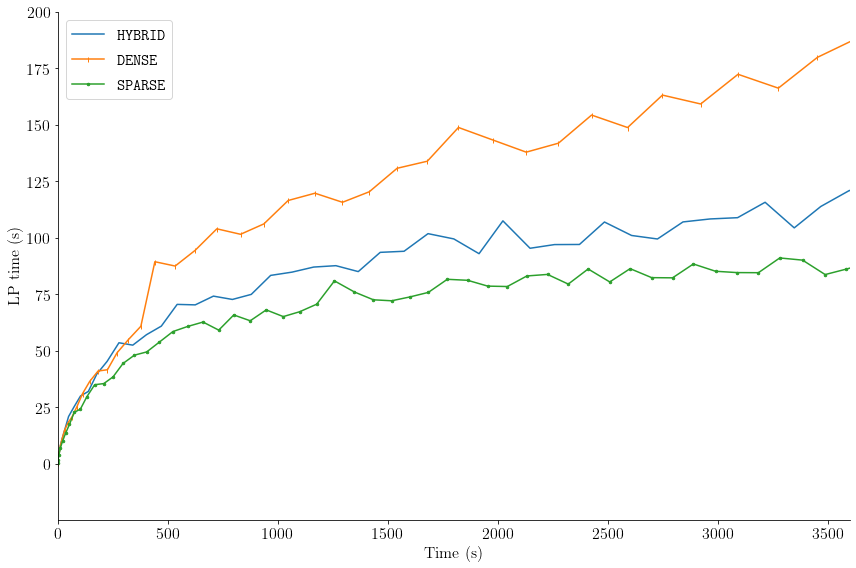

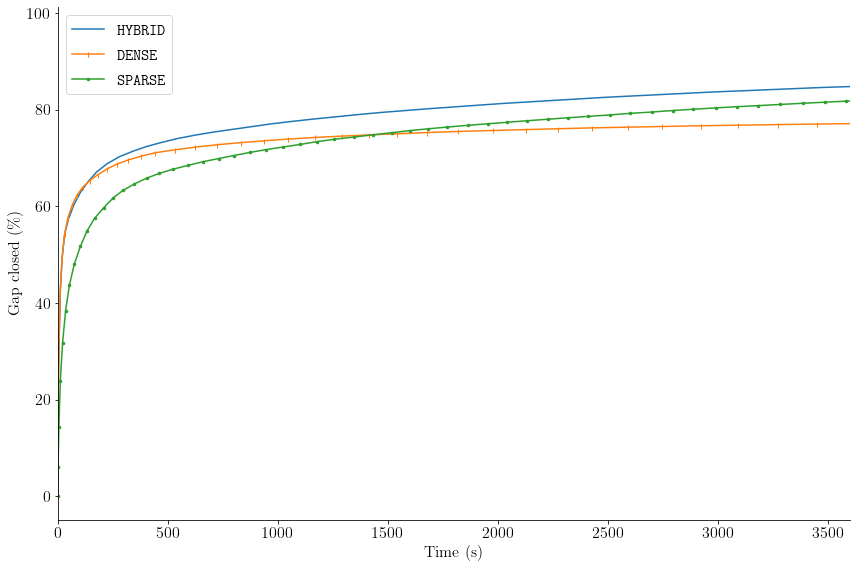

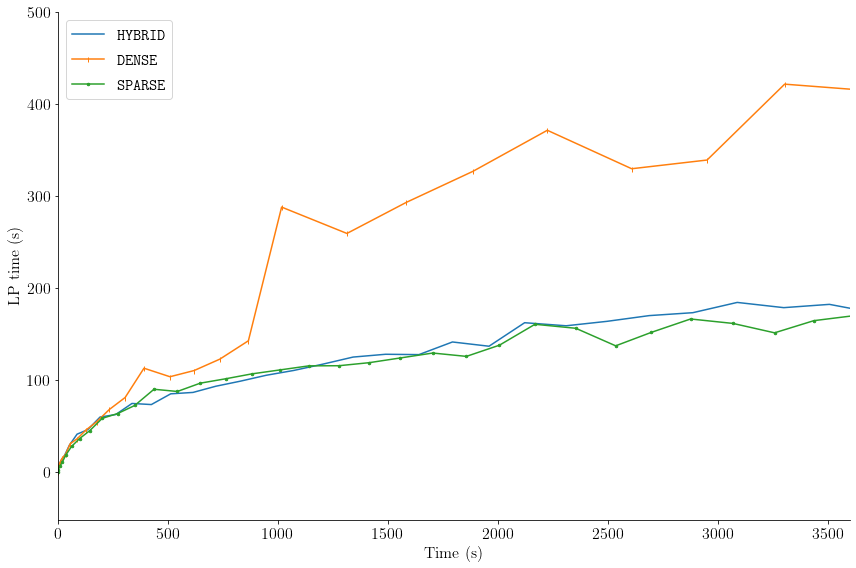

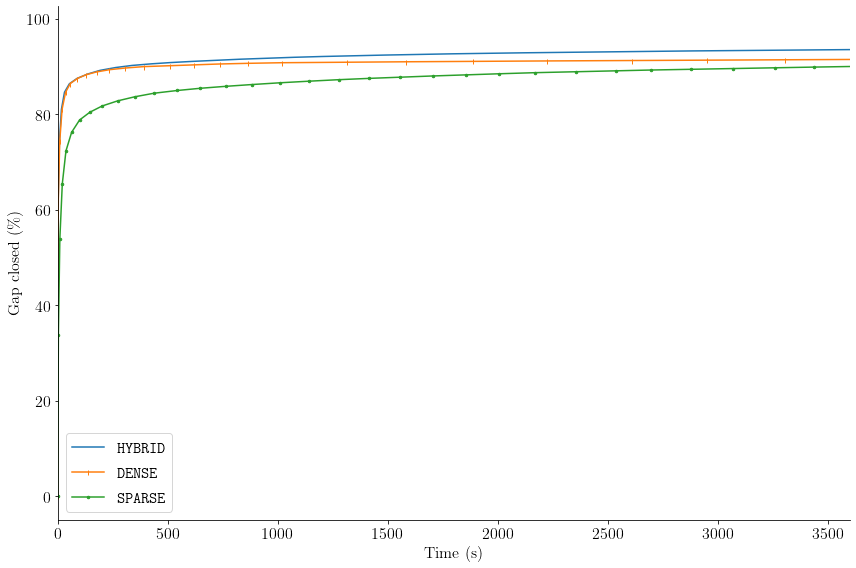

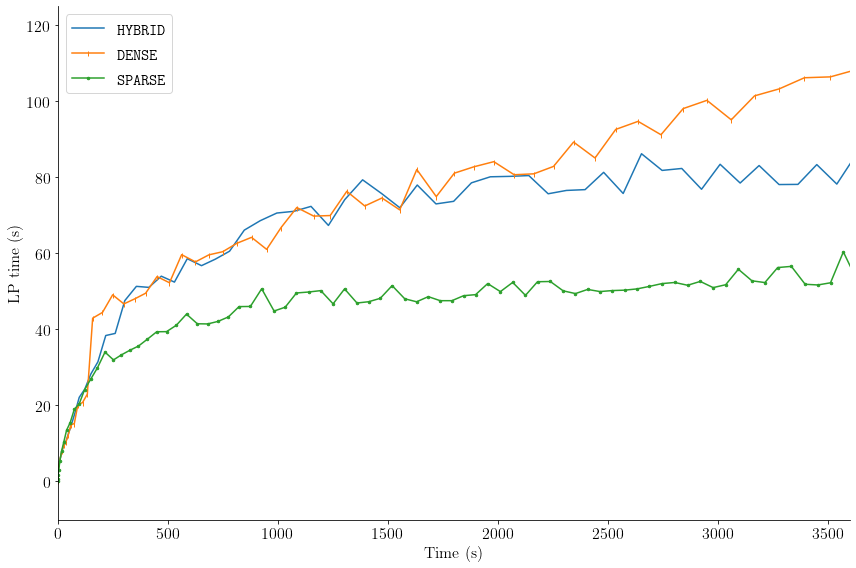

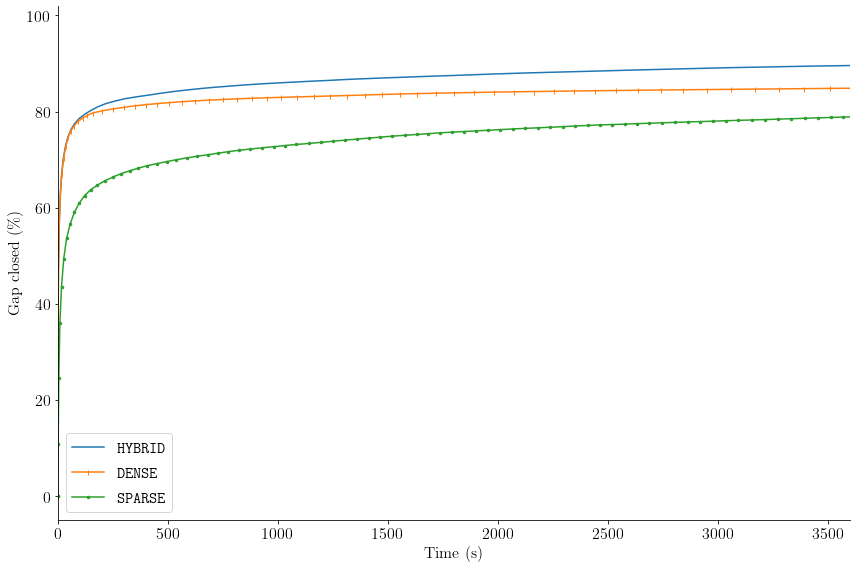

<Figure size 864x576 with 0 Axes>

In [5]:
should_show_title = False
hybrid_stub = "verbose_logfile_shd0.25c1x112_"
dense_stub = "verbose_logfile_sdd1.0c1x112_"
sparse_stub = "verbose_logfile_ssd0.25c1x112_"

instance_ids = ["091", "344", "171"]
instance_names = ["spar125-025-1", "be150.8.2", "pm1s_100.1"]
fam_names = ["boxQP", "biq", "maxcut"]

# instance_ids = [instance_ids[2]]
# instance_names = [instance_names[2]]
# fam_names = [fam_names[2]]

out_ext = '-1hour.pdf'

i = -1
ymax = [200, 500, 125]

for (inst_id, inst_name, fam) in zip(instance_ids, instance_names, fam_names):
    i = i + 1
    #fam = df_instances['set'][inst_name]
    fname = RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id)
    hybrid_instance = pd.read_csv(fname, sep=',', header=1)
    fname = RESULTS_DIR+"dense/"+"%s%s.csv"%(dense_stub,inst_id)
    dense_instance = pd.read_csv(fname, sep=',', header=1)
    fname = RESULTS_DIR+"sparse/"+"%s%s.csv"%(sparse_stub,inst_id)
    sparse_instance = pd.read_csv(fname, sep=',', header=1)

    yaxes = ['Gurobi time', 'Gap closed']
    ylabels = ['LP time (s)', 'Gap closed (\%)']
    fnames = ['%s-time%s'%(inst_name,out_ext), '%s-gap%s'%(inst_name,out_ext)]
    tex_inst_name = tex_escape(inst_name)
    titles = [
        'LP resolve time (%s)'%(tex_inst_name),
        'Percent gap closed with respect to SDP optimum (%s)'%(tex_inst_name)
    ]

    j = 0
    for (yaxis, ylabel, fname, title) in zip(yaxes, ylabels, fnames, titles):
        j = j + 1
        ax = plt.gca()
        hybrid_line = hybrid_instance.plot(x='Time',y=yaxis,kind='line', label="\\texttt{HYBRID}", marker='', markersize=1, ax=ax)
        dense_line = dense_instance.plot(x='Time',y=yaxis,kind='line', label="\\texttt{DENSE}", marker='|', markersize=5, ax=ax)
        sparse_line = sparse_instance.plot(x='Time',y=yaxis,kind='line', label="\\texttt{SPARSE}", marker='.', markersize=5, ax=ax)
        if should_show_title:
            plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel(ylabel)
        plt.xlim(0,3600)
        if j == 1:
            plt.ylim(top=ymax[i])
        #plt.xlim(0,86400)

        fig1 = plt.gcf()

        plt.tight_layout()
        plt.show()
        plt.draw()
        fig1.savefig(fname, dpi=300)

# Scatter plot of gap closed (dense vs hybrid)

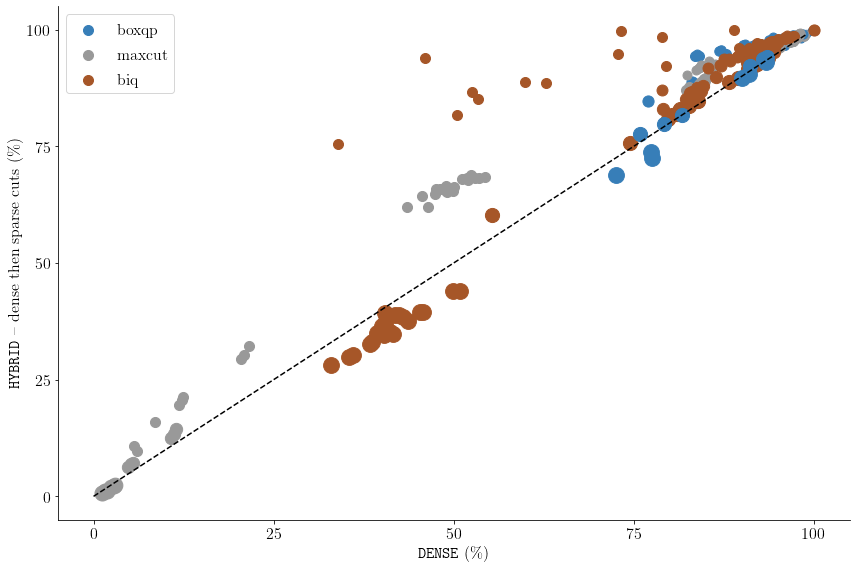

<Figure size 864x576 with 0 Axes>

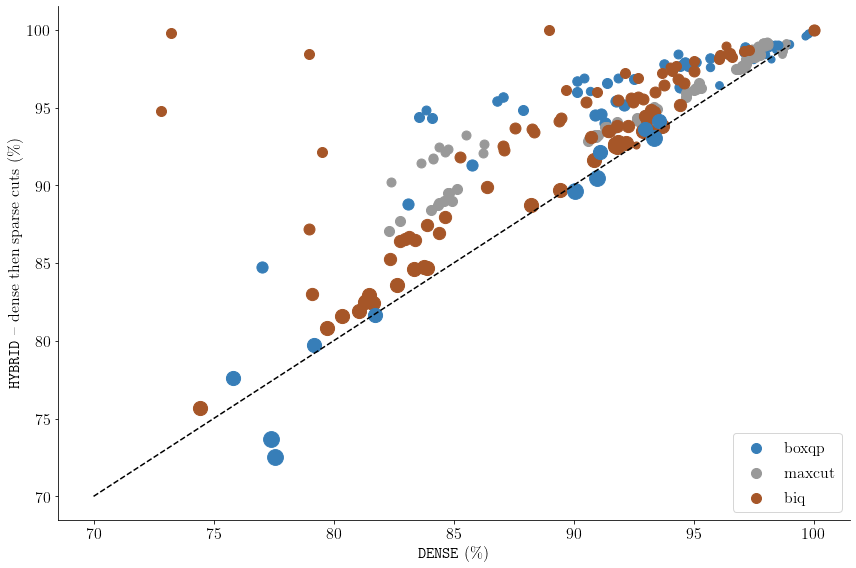

<Figure size 864x576 with 0 Axes>

In [339]:
#col = ['blue', 'orange', 'purple']
# Replaced above with color-blind-friendly palette
col = ['#377eb8', '#ff7f00', '#4daf4a',
'#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']
col = [#'#4daf4a', 
       #'#ff7f00',
       '#377eb8',
        #'#f781bf', 
 #'#984ea3',
'#999999',       '#a65628', '#e41a1c', '#dede00']
inst_families = ['boxqp', 'maxcut', 'biq']
def set_marker_size_density(density):
    return density * 30 + 10
def set_marker_size_n(num_vars):
    return num_vars

sparse_ind = 0
dense_ind = 1
hybrid_ind = 2
dfs = [new_dfs[sparse_ind], new_dfs[dense_ind], new_dfs[hybrid_ind]] # sparse, dense, hybrid

tmpnames = dfs[hybrid_ind].index.intersection(df_dense.index)
gap_h = [dfs[hybrid_ind]['Gap'][tmpnames[i]] for i in range(len(tmpnames))]
gap_d = [dfs[dense_ind]['Gap'][tmpnames[i]] for i in range(len(tmpnames))]
n = [dfs[hybrid_ind]['n'][tmpnames[i]] for i in range(len(tmpnames))]
density_Q0 = df_hybrid['density_Q0'][tmpnames]
inst_family = [df_instances['set'][tmpnames[i]] for i in range(len(tmpnames))]

# Set integer ticks
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))

# Do scatter plot
minx = 100
maxx = 0
miny = 100
maxy = 0
inst_fam_labeled = [False for i in range(len(inst_families))]
for i in range(len(tmpnames)):
    gap_x = gap_d[i] if gap_d[i].size == 1 else gap_d[i][0]
    gap_y = gap_h[i] if gap_h[i].size == 1 else gap_h[i][0]
    if (max(gap_x, gap_y) < 1e-3):
        continue
    density = density_Q0[i] if density_Q0[i].size == 1 else density_Q0[i][0]
    curr_n = n[i] if n[i].size == 1 else n[i][0]
    inst_fam = inst_family[i]
    size = set_marker_size_density(density)
    fam_ind = inst_families.index(inst_fam)
    #size = set_marker_size_density(density)
    #if inst_fam_labeled[fam_ind] or density < .95:
    size = set_marker_size_n(curr_n)
    if inst_fam_labeled[fam_ind] or (size not in [100,101]):
        label = ""
    else:
        label = inst_fam
        inst_fam_labeled[fam_ind] = True
    plt.scatter(gap_x, gap_y, label=label, s=size, color=col[fam_ind])
    if (gap_x > maxx):
        maxx = gap_x
    if (gap_x < minx):
        minx = gap_x
    if (gap_y > maxy):
        maxy = gap_y
    if (gap_y < miny):
        miny = gap_y

minx = 0
maxx = 100
        
plt.plot(range(int(minx),int(maxx)),range(int(minx),int(maxx)),'--', color='black')

#plt.title('Gap closed with respect to QCQP optimum (\%)')
plt.xlabel('\\texttt{DENSE} (\%)')
plt.ylabel('\\texttt{HYBRID} -- dense then sparse cuts (\%)')
plt.legend()

# locs, labels = ax.xticks()
# ax.set_xticks(np.arange(minx, maxx, step=1))
# ax.set_xticklabels(np.arange(minx, maxx, step=10))

fig = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
fname = "hybrid_vs_dense_all_fams.pdf"
fig.savefig(fname, dpi=300)

## Second plot for only instances closing a lot of gap
ax = plt.figure().gca()
# Do scatter plot
minx = 100
maxx = 0
miny = 100
maxy = 0
inst_fam_labeled = [False for i in range(len(inst_families))]
for i in range(len(tmpnames)):
    gap_x = gap_d[i] if gap_d[i].size == 1 else gap_d[i][0]
    gap_y = gap_h[i] if gap_h[i].size == 1 else gap_h[i][0]
#     if tmpnames[i] == 'spar250-025-1':
#         print("here (dense = %f, hybrid = %f" % (gap_x, gap_y))
    if (max(gap_x, gap_y) < 1e-3):
        continue
    if (min(gap_x,gap_y) < 70):
        continue
    density = density_Q0[i] if density_Q0[i].size == 1 else density_Q0[i][0]
    curr_n = n[i] if n[i].size == 1 else n[i][0]
    inst_fam = inst_family[i]
    fam_ind = inst_families.index(inst_fam)
    #size = set_marker_size_density(density)
    #if inst_fam_labeled[fam_ind] or density < .95:
    size = set_marker_size_n(curr_n)
    if inst_fam_labeled[fam_ind] or (size not in [100,101]):
        label = ""
    else:
        label = inst_fam
        inst_fam_labeled[fam_ind] = True
    plt.scatter(gap_x, gap_y, label=label, s=size, color=col[fam_ind])
    if (gap_x > maxx):
        maxx = gap_x
    if (gap_x < minx):
        minx = gap_x
    if (gap_y > maxy):
        maxy = gap_y
    if (gap_y < miny):
        miny = gap_y

minx = 70
maxx = 100
        
plt.plot(range(int(minx),int(maxx)),range(int(minx),int(maxx)),'--', color='black')

#plt.title('Gap closed with respect to QCQP optimum (\%)')
plt.xlabel('\\texttt{DENSE} (\%)')
plt.ylabel('\\texttt{HYBRID} -- dense then sparse cuts (\%)')
plt.legend()

fig = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
fname = "hybrid_vs_dense_all_fams_tail.pdf"
fig.savefig(fname, dpi=300)

# Extract first hour from each instance using verbose logfiles

In [6]:
import os, fnmatch

def parse_verbose_batch(fname):
    is_batch = fname.endswith("_001.csv") or fname.endswith("_002.csv") or fname.endswith("_003.csv") or fname.endswith("_004.csv")
    breaklines = [0]
    inst_names = []
    with open(fname) as f:
        if is_batch:
            lines = f.read().splitlines()
            for i in range(len(lines)):
                line = lines[i]
                if (i==0):
                    inst_names.append(line)
                if (line.split(',')[0] == 'DONE!') and (i+2 < len(lines)):
                    breaklines.append(i+2)
                    inst_names.append(lines[i+2])
        else:
            inst_names.append(f.readline().rstrip('\n'))
            
    return inst_names, breaklines


def get_df_row(inst_name, fname, skiprows, nrows, target_time):
    header_row = 1
    if nrows != None:
        nrows = nrows-header_row
    curr_df = pd.read_csv(fname, sep=',', header=header_row, skiprows=skiprows, nrows=nrows)
    #display(curr_df, skiprows, nrows) ### DEBUG
    last_time = 0
    found_index = -1
    for index,row in curr_df.iterrows():
        found_index = index
        curr_time = row['Time']
        curr_gur_time = row['Gurobi time']
        if float(curr_time) + float(curr_gur_time) >= target_time:
            break
    found_index = min(found_index, len(curr_df)-2)
    found_row = curr_df.iloc[found_index,:]
    found_row.name = inst_name
    return found_row
        

dense_stub = "verbose_logfile_sdd1.0c1x*_"
sparse_stub = "verbose_logfile_ssd0.25c1x*_"
hybrid_stub = "verbose_logfile_shd0.25c1x*_"
exp_types = ["sparse", "dense", "hybrid"]
stubs = [sparse_stub, dense_stub, hybrid_stub]
RESULTS_DIR = "../results/saved/"
target_time = 3600.
new_dfs = []

#for (exp,stub,new_df) in zip(exp_types,stubs,new_dfs):
for i in range(len(exp_types)):
#for i in range(1): ### DEBUG
    exp = exp_types[i]
    stub = stubs[i]
    new_df = pd.DataFrame(columns = df_spar125_hybrid.columns)
    files = os.listdir(RESULTS_DIR + '/' + exp)
    files = fnmatch.filter(files, stub + "*")
    files.sort()
    #files = [files[217]] ### DEBUG
    # Now reach each file and get the last gap closed and Gurobi time for a 1 hour timelimit
    for f_stub in files:
        fname = RESULTS_DIR + '/' + exp + '/' + f_stub
        inst_names, starts = parse_verbose_batch(fname)
        for j in range(len(inst_names)):
            inst_name = inst_names[j]
            if len(inst_name) == 0:
                continue
            if j < len(inst_names)-1:
                nrows = starts[j+1] - starts[j]-2
            else:
                nrows = None
            #display(inst_name, starts[j], nrows, target_time) ### DEBUG
            found_row = get_df_row(inst_name, fname, starts[j], nrows, target_time)
            #display(found_row) ### DEBUG
            new_df = new_df.append(found_row)
            #if inst_name == "bqp50-10":
                #display(exp, stub, new_df.loc[inst_name])
    new_df.insert(len(new_df.columns), 'n', df_instances['n'][new_df.index])
    new_df = new_df.rename(columns={"Gap closed": "Gap"})
    new_dfs.append(new_df)

In [208]:
#inst = 'spar020-100-1'
inst = 'bqp50-9'
display(new_dfs[0].loc[inst])
display(new_dfs[1].loc[inst])
display(new_dfs[2].loc[inst])

Iter                                   0
Max violation             0.000000000000
Objective                           1931
dist2opt                        0.252517
Gap                                    0
Total cuts                             0
Pool                                   0
Active                                 0
Sparse                                 0
Sparse active                          0
Dense                                  0
Dense active                           0
% supp used                            1
Curr Gurobi iters                      9
Total Gurobi iters                     9
Gurobi time                         0.02
Cumulative Gurobi time              0.02
Time                                0.02
Avg dense active iter                NaN
Avg sparse active iter               NaN
Percent supp used                    NaN
n                                     50
Name: bqp50-9, dtype: object

Iter                                   5
Max violation             0.000000867843
Objective                           1931
dist2opt                        0.301292
Gap                              92.5828
Total cuts                             4
Pool                                   4
Active                                 3
Sparse                                 0
Sparse active                          0
Dense                                  4
Dense active                           3
% supp used                            0
Curr Gurobi iters                     11
Total Gurobi iters                    60
Gurobi time                         0.03
Cumulative Gurobi time              0.11
Time                                0.12
Avg dense active iter                NaN
Avg sparse active iter               NaN
Percent supp used                    NaN
n                                     50
Name: bqp50-9, dtype: object

Iter                                   5
Max violation             0.000000867843
Objective                           1931
dist2opt                        0.301292
Gap                              92.5828
Total cuts                             4
Pool                                   4
Active                                 3
Sparse                                 0
Sparse active                          0
Dense                                  4
Dense active                           3
% supp used                            0
Curr Gurobi iters                     11
Total Gurobi iters                    60
Gurobi time                         0.03
Cumulative Gurobi time              0.14
Time                                0.15
Avg dense active iter                NaN
Avg sparse active iter               NaN
Percent supp used                    NaN
n                                     50
Name: bqp50-9, dtype: object

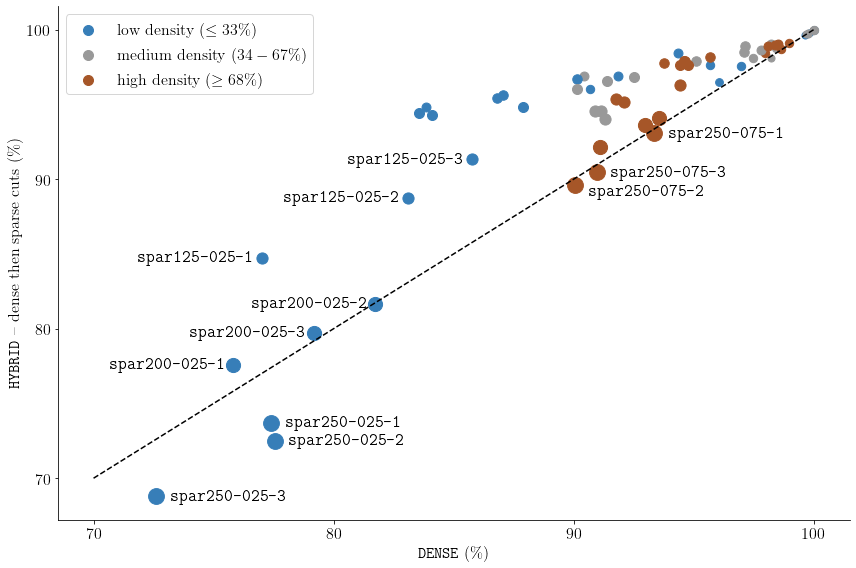

<Figure size 864x576 with 0 Axes>

In [367]:
#col = ['blue', 'orange', 'purple']
# Replaced above with color-blind-friendly palette
col = [#'#4daf4a', 
       #'#ff7f00',
       '#377eb8',
        #'#f781bf', 
 #'#984ea3',
'#999999',       '#a65628', '#e41a1c', '#dede00']
inst_families = ['boxqp']
densities = [.33, .67, 1]
def set_marker_size_density(density):
    return density * 20 + 10
def set_marker_size_n(num_vars):
    return num_vars

sparse_ind = 0
dense_ind = 1
hybrid_ind = 2
dfs = [new_dfs[sparse_ind], new_dfs[dense_ind], new_dfs[hybrid_ind]] # sparse, dense, hybrid

tmpnames = dfs[hybrid_ind].index.intersection(df_dense.index)
gap_h = [dfs[hybrid_ind]['Gap'][tmpnames[i]] for i in range(len(tmpnames))]
gap_d = [dfs[dense_ind]['Gap'][tmpnames[i]] for i in range(len(tmpnames))]
n = [dfs[hybrid_ind]['n'][tmpnames[i]] for i in range(len(tmpnames))]
density_Q0 = df_hybrid['density_Q0'][tmpnames]
inst_family = [df_instances['set'][tmpnames[i]] for i in range(len(tmpnames))]

# Set integer ticks
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(5,integer=True))
ax.yaxis.set_major_locator(MaxNLocator(5,integer=True))

minx = 70
maxx = 101
        
plt.plot(range(int(minx),int(maxx)),range(int(minx),int(maxx)),'--', color='black')

# Do scatter plot
minx = 100
maxx = 0
miny = 100
maxy = 0
dense_fam_labeled = [False for i in range(len(densities))]
for i in (range(len(tmpnames))):
    gap_x = gap_d[i] if gap_d[i].size == 1 else gap_d[i][0]
    gap_y = gap_h[i] if gap_h[i].size == 1 else gap_h[i][0]
    if (max(gap_x, gap_y) < 1e-3):
        continue
    density = density_Q0[i] if density_Q0[i].size == 1 else density_Q0[i][0]
    curr_n = n[i] if n[i].size == 1 else n[i][0]
    inst_fam = inst_family[i]
    #size = set_marker_size_density(density)
    size = set_marker_size_n(curr_n)
    if inst_fam not in inst_families:
        continue
#    fam_ind = inst_families.index(inst_fam)
    if density <= densities[0]:
        fam_ind = 0
    elif density <= densities[1]:
        fam_ind = 1
    else:
        fam_ind = 2
    if dense_fam_labeled[fam_ind] or size != 100:
        label = ""
    else:
        if fam_ind == 0:
            label = "low density ($\\le 33\%$)"
        elif fam_ind == 1:
            label = "medium density ($34-67\%$)"
        else:
            label = "high density ($\ge 68\%$)"
        dense_fam_labeled[fam_ind] = True
    plt.scatter(gap_x, gap_y, label=label, s=size, color=col[fam_ind])
    if tmpnames[i] in ['spar250-025-1', 'spar250-025-2', 'spar250-025-3']:
        #plt.annotate(tmpnames[i], (gap_x+2.5, gap_y), ha='center', va='center', size='xx-large')
        plt.annotate("\\texttt{%s}"%tmpnames[i], (gap_x+3, gap_y), ha='center', va='center', size='xx-large')
    if tmpnames[i] in ['spar250-075-1', 'spar250-075-3']:
        #plt.annotate(tmpnames[i], (gap_x+2.5, gap_y), ha='center', va='center', size='xx-large')
        plt.annotate("\\texttt{%s}"%tmpnames[i], (gap_x+3, gap_y), ha='center', va='center', size='xx-large')
    if tmpnames[i] in ['spar250-075-2',]:
        #plt.annotate(tmpnames[i], (gap_x+2.5, gap_y-0.5), ha='center', va='center', size='xx-large')
        plt.annotate("\\texttt{%s}"%tmpnames[i], (gap_x+3, gap_y-0.5), ha='center', va='center', size='xx-large')
    if tmpnames[i] in ['spar200-025-1', 'spar200-025-2', 'spar200-025-3']:
        #plt.annotate(tmpnames[i], (gap_x-2.5, gap_y), ha='center', va='center', size='xx-large')
        plt.annotate("\\texttt{%s}"%tmpnames[i], (gap_x-2.75, gap_y), ha='center', va='center', size='xx-large')
    if tmpnames[i] in ['spar125-025-1', 'spar125-025-2', 'spar125-025-3']:
        #plt.annotate(tmpnames[i], (gap_x-2.5, gap_y), ha='center', va='center', size='xx-large')
        plt.annotate("\\texttt{%s}"%tmpnames[i], (gap_x-2.75, gap_y), ha='center', va='center', size='xx-large')
    if (gap_x > maxx):
        maxx = gap_x
    if (gap_x < minx):
        minx = gap_x
    if (gap_y > maxy):
        maxy = gap_y
    if (gap_y < miny):
        miny = gap_y

minx = 70
maxx = 101
        
#plt.plot(range(int(minx),int(maxx)),range(int(minx),int(maxx)),'--', color='black')

#plt.title('Gap closed with respect to QCQP optimum (\%)')
plt.xlabel('\\texttt{DENSE} (\%)')
plt.ylabel('\\texttt{HYBRID} -- dense then sparse cuts (\%)')
plt.legend()

#locs, labels = ax.xticks()
ax.set_xticks(np.arange(minx, maxx, step=10))
ax.set_yticks(np.arange(minx, maxx, step=10))
#ax.set_xticklabels(np.arange(minx, maxx, step=10))

fig = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
fname = "hybrid-vs-dense-boxqp.pdf"
fig.savefig(fname, dpi=300)

In [270]:
dfs[sparse_ind].to_csv("sparse_3600.csv")
dfs[dense_ind].to_csv("dense_3600.csv")
dfs[hybrid_ind].to_csv("hybrid_3600.csv")

In [276]:
inst_families = ['boxqp', 'biq', 'maxcut']
fam_name = {'boxqp': 'BoxQP', 'biq': 'Biq', 'maxcut': 'MaxCut'}
ranges = [
    [[20,30], [40,50], [60,90], [100,125], [200,250]],
    #[[20,50], [60,80], [90,125], [200,250]],
    [[20,90], [100,100], [120,150], [200,250]],
    [[60,60], [80,80], [100,100], [150,225]]
]

def find_zero_gap_instances(dfs):
#     return [ 'gka6c',
#              'gka3a',
#              'gka7c',
#              'gka8a',
#              'bqp50-8',
#              'bqp50-7',
#              'bqp50-5',
#              'gka1a',
#              'bqp50-6',
#              'bqp50-2',
#              'gka2a',
#              'bqp50-1',
#              'bqp50-3',
#              'bqp50-4',
#              'bqp50-9']
    tmpnames = dfs[0].index
    tmpnames = tmpnames.intersection(dfs[1].index)
    tmpnames = tmpnames.intersection(dfs[2].index)
    zero_instances = []
    for inst_name in tmpnames:
        gaps = []
        for i in range(len(dfs)):
            gaps.append(dfs[i]['Gap'][inst_name])
        if max(gaps) < 1e-7:
            zero_instances.append(inst_name)
    # Add some instances that we manually have detected should be there
    if "bqp50-9" not in zero_instances:
        zero_instances.append("bqp50-9")
    return zero_instances

def print_gap_and_time_table(ranges, fam, dfs, target_time):
    # Exclude zero-gap instances
    zero_gap_instances = find_zero_gap_instances(dfs)
    
    # Ensure only instances common to all sets are taken
    tmpnames = dfs[0].index
    tmpnames = tmpnames.intersection(dfs[1].index)
    tmpnames = tmpnames.intersection(dfs[2].index)
    common_names = tmpnames
    
    tab = []
    total_num_inst = 0
    for curr_range in ranges:
        curr_row = []
        num_inst = -1
        stats = []
        for curr_df in dfs:
            # instances from max cut are off by one due to constant term in objective encoded as C
            lower_range = (curr_df['n'] >= curr_range[0])
            upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
            in_fam = df_instances['set'][curr_df.index] == fam
            nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
            common_inst = curr_df.index.isin(common_names)
            curr_df = curr_df[lower_range & upper_range & in_fam & nonzero_inst & common_inst]
            curr_num_inst = len(curr_df)
            if num_inst >= 0:
                assert(curr_num_inst == num_inst)
            else:
                num_inst = curr_num_inst
            stats.append([curr_df['Gap'].mean(), curr_df['Gurobi time'].mean()])
        total_num_inst += num_inst
        if curr_range[0] != curr_range[1]:
            curr_row.append("$n \in [%d,%d]$"%(curr_range[0], curr_range[1]))
        else:
            curr_row.append("$n = %d$"%(curr_range[0]))
        curr_row.append("%d"%(num_inst))
        curr_row.extend([stats[i][0] for i in range(3)])
        curr_row.extend([stats[i][1] for i in range(3)])
        tab.append(curr_row)

    caption = (r"Results on %d %s instances for \SPARSE, \DENSE, and \HYBRID." % (total_num_inst, fam_name[fam])
               + " Results are averages over instances grouped by size, under a time limit of %s." % (target_time))
    return matrix2latex(
        tab, 
        None,
        "table", "center", "tabular",
        headerRow=[
            ["","",r"Gap closed (%)",r"Gap closed (%)",r"Gap closed (%)", "Last LP time (s)", "Last LP time (s)", "Last LP time (s)"],
            [r"Instance group",r"#",r"\SPARSE",r"\DENSE",r"\HYBRID",r"\SPARSE",r"\DENSE",r"\HYBRID"]
        ],
        alignment=r"@{} lc *{3}{c} *{3}{c} @{}",
        label="table:%s"%fam,
        formatColumn=["%s","%d","%.2f","%.2f","%.2f","%.2f","%.2f","%.2f"],
        summaryrows = 0,
        midruleIndex = [],
        caption=caption,
        position="t"
    )


full_dfs = [df_sparse, df_dense, df_hybrid]

print("\n## family: %s" % inst_families[0])
print(print_gap_and_time_table(ranges[0], inst_families[0], full_dfs, "1 day"))
print(print_gap_and_time_table(ranges[0], inst_families[0], new_dfs, "1 hour"))

print("\n## family: %s" % inst_families[1])
print(print_gap_and_time_table(ranges[1], inst_families[1], full_dfs, "1 day"))
print(print_gap_and_time_table(ranges[1], inst_families[1], new_dfs, "1 hour"))

print("\n## family: %s" % inst_families[2])
print(print_gap_and_time_table(ranges[2], inst_families[2], full_dfs, "1 day"))
print(print_gap_and_time_table(ranges[2], inst_families[2], new_dfs, "1 hour"))


## family: boxqp
\begin{table}[t]
  \begin{center}
  \caption{Results on 111 BoxQP instances for \SPARSE, \DENSE, and \HYBRID. Results are averages over instances grouped by size, under a time limit of 1 day.}
  \label{tab:table:boxqp}
    \begin{tabular}{@{} lc *{3}{c} *{3}{c} @{}}
    \toprule
      {} & {} & \multicolumn{3}{c}{Gap closed (\%)} & \multicolumn{3}{c}{Last LP time (s)}\\\cmidrule(r){3-5}\cmidrule(r){6-8}
      {Instance group} & {\#} & {\SPARSE} & {\DENSE} & {\HYBRID} & {\SPARSE} & {\DENSE} & {\HYBRID}\\
      \midrule
      {$n \in [20,30]$} & {18} & {98.50} & {100.00} & {100.00} & {0.10} & {2.93} & {2.93}\\
      {$n \in [40,50]$} & {33} & {98.81} & {99.95} & {99.95} & {0.65} & {10.88} & {7.41}\\
      {$n \in [60,90]$} & {30} & {98.77} & {99.30} & {98.79} & {9.05} & {55.35} & {13.10}\\
      {$n \in [100,125]$} & {18} & {98.40} & {96.22} & {98.45} & {73.30} & {263.16} & {89.19}\\
      {$n \in [200,250]$} & {12} & {86.61} & {88.68} & {91.22} & {2048.25} & {3252.15} 

In [11]:
inst = 'spar200-025-1'
curr_range = [90,125]
curr_df = new_dfs[0]
fam = 'boxqp'
lower_range = (curr_df['n'] >= curr_range[0])
upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
in_fam = df_instances['set'][curr_df.index] == fam
#nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
#common_inst = curr_df.index.isin(common_names)
curr_df = curr_df[lower_range & upper_range & in_fam]
curr_df.to_csv("sparse90-125.csv")

In [12]:
inst = 'spar200-025-1'
curr_range = [90,125]
curr_df = new_dfs[2]
fam = 'boxqp'
lower_range = (curr_df['n'] >= curr_range[0])
upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
in_fam = df_instances['set'][curr_df.index] == fam
#nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
#common_inst = curr_df.index.isin(common_names)
curr_df = curr_df[lower_range & upper_range & in_fam]
curr_df.to_csv("hybrid90-125.csv")

In [13]:
zero_gap_instances = find_zero_gap_instances(new_dfs)
curr_df = df_sparse
df1 = curr_df[(~curr_df.index.isin(zero_gap_instances)) & (curr_df['n'] >= 20) & (curr_df['n'] <= 90)
         & (df_instances['set'][curr_df.index] == 'biq')]
curr_df = new_dfs[0]
df2 = curr_df[(~curr_df.index.isin(zero_gap_instances)) & (curr_df['n'] >= 20) & (curr_df['n'] <= 90)
         & (df_instances['set'][curr_df.index] == 'biq
df1['Gap closed'][df1.index], df2['Gap closed'][df1.index]

In [14]:
# def get_df_row(inst_name, fname, skiprows, nrows, target_time):
#     curr_df = pd.read_csv(fname, sep=',', header=1, skiprows=skiprows, nrows=nrows)
#     last_time = 0
#     found_index = -1
#     for index,row in curr_df.iterrows():
#         found_index = index
#         curr_time = row['Time']
#         curr_gur_time = row['Gurobi time']
#         if float(curr_time) + float(curr_gur_time) >= target_time:
#             break
#     found_index = min(found_index, len(curr_df)-2)
#     found_row = curr_df.iloc[found_index,:]
#     found_row.name = inst_name
#     return found_row

# new_df = pd.DataFrame(columns = df_spar125_hybrid.columns)
# fname = RESULTS_DIR + '/sparse/verbose_logfile_ssd0.25c1x112_289.csv'
# inst_names, starts = parse_verbose_batch(fname)
# for j in range(len(inst_names)):
#     inst_name = inst_names[j]
#     if len(inst_name) == 0:
#         continue
#     #display(inst_name)
#     if j < len(inst_names)-1:
#         nrows = starts[j+1] - starts[j]-2
#     else:
#         nrows = None
#     found_row = get_df_row(inst_name, fname, starts[j], nrows, 3600.)
#     new_df = new_df.append(found_row)

# new_df.head()

,Iter,Max violation,Objective,dist2opt,Gap closed,Total cuts,Pool,Active,Sparse,Sparse active,Dense,Dense active,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time
bqp50-10,56,0.026919579608,1748.660326,1.441555,96.698369,2168.0,228.0,218.0,228.0,218.0,0.0,0.0,1.0,23.0,1053.0,0.31,16.21,17.96


In [26]:
# hybrid_stub = "verbose_logfile_shd0.25c1x112_"
# dense_stub = "verbose_logfile_sdd1.0c1x112_"
# sparse_stub = "verbose_logfile_ssd0.25c1x112_"
# inst_id = "091" # spar125-025-1 (boxqp)
# # inst_id = "344" # be150.8.2 (maxcut)
# # inst_id = "171" # pm1s_100.1 (biq)
# #inst = "boxQP"
# #inst = "maxcut"
# #inst = "biq"
# df_spar125_hybrid = pd.read_csv(RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id), sep=',', header=1)
# df_spar125_dense = pd.read_csv(RESULTS_DIR+"dense/"+"%s%s.csv"%(dense_stub,inst_id), sep=',', header=1)
# df_spar125_sparse = pd.read_csv(RESULTS_DIR+"sparse/"+"%s%s.csv"%(sparse_stub,inst_id), sep=',', header=1)

In [131]:

# fname = RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id)
# with open(fname,newline='\n') as f:
#     inst_name = f.readline()
#     display(inst_name.rstrip('\n'))
    
# new_df = pd.DataFrame(columns = df_spar125_hybrid.columns)
# #new_df.insert(0, "Name", value=None)
# last_time = 0
# target_time = 3600
# found_index = -1
# for index,row in df_spar125_hybrid.iterrows():
#     found_index = index
#     curr_time = row['Time']
#     curr_gur_time = row['Gurobi time']
#     if curr_time + curr_gur_time >= target_time:
#         break
# found_row = df_spar125_hybrid.iloc[found_index,:]
# found_row.name = "Test instance"
# new_df = new_df.append(found_row)
# new_df

,Iter,Max violation,Objective,dist2opt,Gap closed,Total cuts,Pool,Active,Sparse,Sparse active,Dense,Dense active,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time
Test instance,45,0.580588608788,6727.142147,15.62377,84.7572,24732.0,6089.0,4858.0,5842.0,4615.0,247.0,243.0,1.0,14.0,660.0,120.99,3098.04,3599.7


In [117]:
# new_df = pd.DataFrame(columns = df_spar125_hybrid.columns)
# new_df.insert(0, "Name", value=None)
# display(new_df.iloc[0,:])
# new_df.index[0]

Name                                 NaN
Iter                                  45
Max violation             0.580588608788
Objective                        6727.14
dist2opt                         15.6238
Gap closed                       84.7572
Total cuts                         24732
Pool                                6089
Active                              4858
Sparse                              5842
Sparse active                       4615
Dense                                247
Dense active                         243
% supp used                            1
Curr Gurobi iters                     14
Total Gurobi iters                   660
Gurobi time                       120.99
Cumulative Gurobi time           3098.04
Time                              3599.7
Name: 45, dtype: object

45

In [123]:
# new_df.rename(index={45: "testname"}, inplace=True)
# new_df.index[0]

'testname'

In [124]:
# test_df = df_spar125_hybrid.iloc[found_index,:]

In [140]:
# test_df = pd.read_csv(RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id), sep=',', header=1)

In [148]:
# fname = RESULTS_DIR+"hybrid/"+"%s%s.csv"%(hybrid_stub,inst_id)
# with open(fname,newline='\n') as f:
#     inst_name = f.readline()
#     display(inst_name.rstrip('\n'))

'spar125-025-1'

In [274]:
# df_instances['set']['pm1s_100.1']

'maxcut'

In [33]:
# #ranges = [[20,50], [60,80], [90,125], [200,250]]
# ranges = [[20,50], [60,80], [90,125]]
# inst_families = ['boxqp', 'maxcut', 'biq']

# fam = inst_families[1]
# curr_range = ranges[0]
# curr_df = df_sparse
# lower_range = (curr_df['n'] >= curr_range[0])
# upper_range = (curr_df['n'] <= curr_range[1])
# in_fam = df_instances['set'][curr_df.index] == fam
# curr_df = curr_df[lower_range & upper_range & in_fam]
# #print(curr_df['Gap'].mean())
# #print(len(curr_df))
# print(curr_df)

Empty DataFrame
Columns: [Name, Gap, Init Obj, Final Obj, Opt Obj, Dist to opt, Iter, Cuts, Pool, Active, Avg pct active, Sparse, Sparse pool, Sparse active, Sparse pct avg active, Sparse avg iter active, Dense, Dense pool, Dense active, Dense pct avg active, Dense avg iter active, First sparse iter, Gurobi iters, Gurobi time, Cumulative Gurobi time, Time, n, m, m_Q, density_Q0, density_c, avg_density_Qk, avg_density_Ak, Strategy, BOUND_TIGHTENING, CLEANUP_FREQUENCY, CUTS_INITIAL_SCORE, METHOD, NEGONLY, TEMP, MATRIX, TPOWER, SEQUENCE, ITER, SEED, ADDALL, EPS, LAMBDA, TARGET_DENSITY, TIMELIMIT, VIOLATION_THRESHOLD_PARAM_IND, Version, ExitReason, date, inst, done]
Index: []

[0 rows x 56 columns]


In [36]:
print(print_gap_and_time_table(ranges[0], inst_families[0], new_dfs, "1 hour"))

\begin{table}[t]
  \begin{center}
  \caption{Results on 111 BoxQP instances for \SPARSE, \DENSE, and \HYBRID. Results are averages over instances grouped by size, under a time limit of 1 hour.}
  \label{tab:table:boxqp}
    \begin{tabular}{@{} lc *{3}{c} *{3}{c} @{}}
    \toprule
      {} & {} & \multicolumn{3}{c}{Gap closed (\%)} & \multicolumn{3}{c}{Last LP time (s)}\\\cmidrule(r){3-5}\cmidrule(r){6-8}
      {Instance group} & {\#} & {\SPARSE} & {\DENSE} & {\HYBRID} & {\SPARSE} & {\DENSE} & {\HYBRID}\\
      \midrule
      {$n \in [20,30]$} & {18} & {-} & {-} & {-} & {-} & {-} & {-}\\
      {$n \in [40,50]$} & {33} & {98.14} & {99.48} & {99.32} & {1.15} & {12.54} & {5.64}\\
      {$n \in [60,80]$} & {21} & {98.10} & {95.84} & {97.95} & {7.12} & {26.52} & {11.04}\\
      {$n \in [90,125]$} & {27} & {94.62} & {90.68} & {95.48} & {48.09} & {106.54} & {49.08}\\
      {$n \in [200,250]$} & {12} & {75.16} & {84.70} & {83.92} & {520.24} & {764.30} & {506.98}\\
    \bottomrule
    \end{tabul

In [37]:
ranges[0]

[[20, 30], [40, 50], [60, 80], [90, 125], [200, 250]]

In [43]:
new_dfs[0].loc['spar020-100-2']

Iter                                         DONE!
Max violation             Sun Oct 25 17:56:05 2020
Objective                                      NaN
dist2opt                                       NaN
Gap                                            NaN
Total cuts                                     NaN
Pool                                           NaN
Active                                         NaN
Sparse                                         NaN
Sparse active                                  NaN
Dense                                          NaN
Dense active                                   NaN
% supp used                                    NaN
Curr Gurobi iters                              NaN
Total Gurobi iters                             NaN
Gurobi time                                    NaN
Cumulative Gurobi time                         NaN
Time                                           NaN
Avg dense active iter                          NaN
Avg sparse active iter         

In [99]:
import os, fnmatch

def parse_verbose_batch(fname):
    is_batch = fname.endswith("_001.csv") or fname.endswith("_002.csv") or fname.endswith("_003.csv") or fname.endswith("_004.csv")
    breaklines = [0]
    inst_names = []
    with open(fname) as f:
        if is_batch:
            lines = f.read().splitlines()
            for i in range(len(lines)):
                line = lines[i]
                if (i==0):
                    inst_names.append(line)
                if (line.split(',')[0] == 'DONE!') and (i+2 < len(lines)):
                    breaklines.append(i+2)
                    inst_names.append(lines[i+2])
        else:
            inst_names.append(f.readline().rstrip('\n'))
            
    return inst_names, breaklines


def get_df_row(inst_name, fname, skiprows, nrows, target_time):
    header_row = 1
    if nrows != None:
        nrows = nrows-header_row-1
    print(inst_name, skiprows, nrows, target_time)
    curr_df = pd.read_csv(fname, sep=',', header=header_row, skiprows=skiprows, nrows=nrows)
    print(curr_df)
    last_time = 0
    found_index = -1
    for index,row in curr_df.iterrows():
        found_index = index
        curr_time = row['Time']
        curr_gur_time = row['Gurobi time']
        if float(curr_time) + float(curr_gur_time) >= target_time:
            break
    print(found_index, len(curr_df))
    found_index = min(found_index, len(curr_df)-1)
    print(found_index)
    found_row = curr_df.iloc[found_index,:]
    found_row.name = inst_name
    print(found_row)
    return found_row
        

dense_stub = "verbose_logfile_sdd1.0c1x*_"
sparse_stub = "verbose_logfile_ssd0.25c1x*_"
hybrid_stub = "verbose_logfile_shd0.25c1x*_"
exp_types = ["hybrid"]
stubs = [hybrid_stub]
RESULTS_DIR = "../results/saved/"
target_time = 3600.
new_dfs = []

#for (exp,stub,new_df) in zip(exp_types,stubs,new_dfs):
for i in range(len(exp_types)):
    exp = exp_types[i]
    stub = stubs[i]
    new_df = pd.DataFrame(columns = df_spar125_hybrid.columns)
    files = os.listdir(RESULTS_DIR + '/' + exp)
    files = fnmatch.filter(files, stub + "*")
    files.sort()
    # Now reach each file and get the last gap closed and Gurobi time for a 1 hour timelimit
    for f_stub in files:
        fname = RESULTS_DIR + '/' + exp + '/' + f_stub
        inst_names, starts = parse_verbose_batch(fname)
        for j in range(len(inst_names)):
            inst_name = inst_names[j]
            if len(inst_name) == 0:
                continue
            #display(inst_name)
            if j < len(inst_names)-1:
                nrows = starts[j+1] - starts[j]-2
            else:
                nrows = None
            found_row = get_df_row(inst_name, fname, starts[j], nrows, target_time)
            print(inst_name, j, starts[j], nrows, target_time, found_row)
            new_df = new_df.append(found_row)
            #if inst_name == "bqp50-10":
                #display(exp, stub, new_df.loc[inst_name])
            break
        break
    new_df.insert(len(new_df.columns), 'n', df_instances['n'][new_df.index])
    new_df = new_df.rename(columns={"Gap closed": "Gap"})
    new_dfs.append(new_df)

spar020-100-1 0 42 3600.0
    Iter  Max violation    Objective  dist2opt  Gap closed  Total cuts  Pool  \
0      0   0.000000e+00  1066.000000  7.356008    0.000000           0     0   
1      1   1.147189e+00   787.829569  7.220747   77.380201          11    11   
2      2   9.337937e-01   741.632803  2.907573   90.231010          19    19   
3      3   2.077953e-01   724.688795  1.516258   94.944418          28    28   
4      4   1.007014e-01   717.015942  1.974591   97.078818          37    34   
5      5   1.131148e-01   712.534712  2.452899   98.325386          46    40   
6      6   4.691577e-02   711.249281  0.358466   98.682962          54    43   
7      7   2.801266e-02   710.058277  1.014960   99.014270          62    47   
8      8   2.001166e-02   709.011219  1.683317   99.305536          70    50   
9      9   1.360301e-02   708.390786  1.722108   99.478125          78    54   
10    10   1.502989e-02   707.683756  1.241065   99.674804          86    55   
11    11   1.1

In [74]:
starts

[0,
 46,
 203,
 218,
 846,
 871,
 1113,
 1918,
 1949,
 2112,
 2584,
 2601,
 2622,
 2684,
 2743,
 2766,
 2877,
 3225,
 3404,
 3509,
 3619,
 3726,
 4693,
 4747,
 5474,
 6222,
 6572,
 6882,
 7741,
 7858,
 7888,
 8021,
 8104,
 8259,
 8458,
 8558,
 8746,
 8968,
 9216,
 9271,
 9368,
 9770,
 10666,
 10861,
 11450,
 12085,
 12448,
 13225,
 13384,
 15600,
 16534]

In [205]:
fname = '../results/saved//hybrid/verbose_logfile_shd0.25c1x112_288.csv'
#fname = '../results/saved//sparse/verbose_logfile_ssd0.25c1x112_289.csv'
pd.read_csv(fname, sep=',', header=1, skiprows=0, nrows=None)
#fname = '../results/saved/hybrid/verbose_test.csv'
#pd.read_csv(fname)

,Iter,Max violation,Objective,dist2opt,Gap closed,Total cuts,Pool,Active,Sparse,Sparse active,Dense,Dense active,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time
0,0,0.000000000000,1931.000001,0.252517,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,9.0,0.02,0.02,0.02
1,1,0.000013635219,1931.000004,0.272140,-430.429416,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,9.0,18.0,0.03,0.02,0.02
2,2,0.029208696427,1931.000000,0.261287,91.008002,2.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,10.0,28.0,0.04,0.05,0.05
3,3,0.000181744322,1931.000004,2.020735,-347.484814,3.0,3.0,2.0,0.0,0.0,3.0,2.0,1.0,10.0,38.0,0.03,0.08,0.09
4,4,0.000003422907,1931.000000,0.301292,92.582769,4.0,4.0,3.0,0.0,0.0,4.0,3.0,1.0,11.0,49.0,0.03,0.11,0.12
5,5,0.000000867843,1931.000000,0.301292,92.582769,4.0,4.0,3.0,0.0,0.0,4.0,3.0,0.0,11.0,60.0,0.03,0.14,0.15
6,DONE!,Sun Oct 25 19:16:10 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
nrows

In [93]:
nrows == None

True

In [110]:
inst_families = ['boxqp', 'biq', 'maxcut']
fam_name = {'boxqp': 'BoxQP', 'biq': 'Biq', 'maxcut': 'MaxCut'}
ranges = [
    [[20,30], [40,50], [60,80], [90,125], [200,250]],
    #[[20,50], [60,80], [90,125], [200,250]],
    [[20,90]],
    [[60,60], [80,80], [100,100], [150,225]]
]

def find_zero_gap_instances(dfs):
    tmpnames = dfs[0].index
    tmpnames = tmpnames.intersection(dfs[1].index)
    tmpnames = tmpnames.intersection(dfs[2].index)
    zero_instances = []
    for inst_name in tmpnames:
        gaps = []
        for i in range(len(dfs)):
            gaps.append(dfs[i]['Gap'][inst_name])
        if max(gaps) < 1e-7:
            zero_instances.append(inst_name)
    return zero_instances

def print_gap_and_time_table(ranges, fam, dfs, target_time):
    # Exclude zero-gap instances
    zero_gap_instances = find_zero_gap_instances(dfs)
    
    # Ensure only instances common to all sets are taken
    tmpnames = dfs[0].index
    tmpnames = tmpnames.intersection(dfs[1].index)
    tmpnames = tmpnames.intersection(dfs[2].index)
    common_names = tmpnames
    
    tab = []
    total_num_inst = 0
    for curr_range in ranges:
        curr_row = []
        num_inst = -1
        stats = []
        for curr_df in dfs:
            # instances from max cut are off by one due to constant term in objective encoded as C
            lower_range = (curr_df['n'] >= curr_range[0])
            upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
            in_fam = df_instances['set'][curr_df.index] == fam
            nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
            common_inst = curr_df.index.isin(common_names)
            curr_df = curr_df[lower_range & upper_range & in_fam & nonzero_inst & common_inst]
            curr_num_inst = len(curr_df)
            if num_inst >= 0:
                assert(curr_num_inst == num_inst)
            else:
                num_inst = curr_num_inst
            stats.append([curr_df['Gap'].mean(), curr_df['Gurobi time'].mean()])
        total_num_inst += num_inst
        if curr_range[0] != curr_range[1]:
            curr_row.append("$n \in [%d,%d]$"%(curr_range[0], curr_range[1]))
        else:
            curr_row.append("$n = %d$"%(curr_range[0]))
        curr_row.append("%d"%(num_inst))
        curr_row.extend([stats[i][0] for i in range(3)])
        curr_row.extend([stats[i][1] for i in range(3)])
        tab.append(curr_row)

    caption = (r"Results on %d %s instances for \SPARSE, \DENSE, and \HYBRID." % (total_num_inst, fam_name[fam])
               + " Results are averages over instances grouped by size, under a time limit of %s." % (target_time))
    return matrix2latex(
        tab, 
        None,
        "table", "center", "tabular",
        headerRow=[
            ["","",r"Gap closed (%)",r"Gap closed (%)",r"Gap closed (%)", "Last LP time (s)", "Last LP time (s)", "Last LP time (s)"],
            [r"Instance group",r"#",r"\SPARSE",r"\DENSE",r"\HYBRID",r"\SPARSE",r"\DENSE",r"\HYBRID"]
        ],
        alignment=r"@{} lc *{3}{c} *{3}{c} @{}",
        label="table:%s"%fam,
        formatColumn=["%s","%d","%.2f","%.2f","%.2f","%.2f","%.2f","%.2f"],
        summaryrows = 0,
        midruleIndex = [],
        caption=caption,
        position="t"
    )

print(print_gap_and_time_table(ranges[1], inst_families[1], full_dfs, "1 day"))
print(print_gap_and_time_table(ranges[1], inst_families[1], new_dfs, "1 hour"))

\begin{table}[t]
  \begin{center}
  \caption{Results on 19 Biq instances for \SPARSE, \DENSE, and \HYBRID. Results are averages over instances grouped by size, under a time limit of 1 day.}
  \label{tab:table:biq}
    \begin{tabular}{@{} lc *{3}{c} *{3}{c} @{}}
    \toprule
      {} & {} & \multicolumn{3}{c}{Gap closed (\%)} & \multicolumn{3}{c}{Last LP time (s)}\\\cmidrule(r){3-5}\cmidrule(r){6-8}
      {Instance group} & {\#} & {\SPARSE} & {\DENSE} & {\HYBRID} & {\SPARSE} & {\DENSE} & {\HYBRID}\\
      \midrule
      {$n \in [20,90]$} & {19} & {93.51} & {99.57} & {99.43} & {1.27} & {21.30} & {6.87}\\
    \bottomrule
    \end{tabular}
  \end{center}
\end{table}
\begin{table}[t]
  \begin{center}
  \caption{Results on 31 Biq instances for \SPARSE, \DENSE, and \HYBRID. Results are averages over instances grouped by size, under a time limit of 1 hour.}
  \label{tab:table:biq}
    \begin{tabular}{@{} lc *{3}{c} *{3}{c} @{}}
    \toprule
      {} & {} & \multicolumn{3}{c}{Gap closed (\%)} &

In [154]:
fam = 'biq'
dfs = new_dfs
tmpnames = dfs[0].index
tmpnames = tmpnames.intersection(dfs[1].index)
tmpnames = tmpnames.intersection(dfs[2].index)
common_names = tmpnames
#curr_df = dfs[1]
curr_df = dfs[1]
lower_range = (curr_df['n'] >= curr_range[0])
upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
sum(df_instances['set'][curr_df.index] == fam)
in_fam = df_instances['set'][curr_df.index] == fam
nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
common_inst = curr_df.index.isin(common_names)
curr_df = curr_df[lower_range & upper_range & in_fam & nonzero_inst & common_inst]
# curr_num_inst = len(curr_df)

In [155]:
#zero_gap_instances
#common_names
#common_inst
#in_fam
#curr_df = curr_df[lower_range & upper_range & in_fam & nonzero_inst & common_inst]
curr_df

,Iter,Max violation,Objective,dist2opt,Gap,Total cuts,Pool,Active,Sparse,Sparse active,...,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time,Avg dense active iter,Avg sparse active iter,Percent supp used,n
bqp50-9,DONE!,Sun Oct 25 21:13:10 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
bqp50-10,DONE!,Sun Oct 25 21:22:17 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
gka1b,DONE!,Sun Oct 25 21:13:08 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
gka1c,DONE!,Sun Oct 25 21:13:24 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
gka2b,DONE!,Sun Oct 25 21:19:11 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
gka2c,DONE!,Sun Oct 25 21:22:45 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
gka3b,DONE!,Sun Oct 25 21:18:08 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
gka4b,DONE!,Sun Oct 25 21:19:48 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
gka5a,DONE!,Sun Oct 25 21:30:08 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
gka6a,DONE!,Sun Oct 25 21:22:24 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30


In [147]:
curr_df = dfs[1]

In [149]:
lower_range = (curr_df['n'] >= curr_range[0])
upper_range = (curr_df['n'] <= curr_range[1] + (1 if fam == 'maxcut' else 0))
sum(df_instances['set'][curr_df.index] == fam)
nonzero_inst = ~curr_df.index.isin(zero_gap_instances)
common_inst = curr_df.index.isin(common_names)

In [153]:
curr_df[lower_range & upper_range & in_fam]

<ipython-input-153-40af8a06d46e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_df[lower_range & upper_range & in_fam]


,Iter,Max violation,Objective,dist2opt,Gap,Total cuts,Pool,Active,Sparse,Sparse active,...,% supp used,Curr Gurobi iters,Total Gurobi iters,Gurobi time,Cumulative Gurobi time,Time,Avg dense active iter,Avg sparse active iter,Percent supp used,n


In [212]:
zero_gap_instances

['gka6c',
 'gka3a',
 'gka7c',
 'gka8a',
 'bqp50-8',
 'bqp50-7',
 'bqp50-5',
 'gka1a',
 'bqp50-6',
 'bqp50-2',
 'gka2a',
 'bqp50-1',
 'bqp50-3',
 'bqp50-4',
 'bqp50-9']

In [311]:
col = 'Gurobi time'
col = 'Gap'
#inst = 'spar125-025-1'
#inst = 'be150.8.2'
inst = 'pm1s_100.1'
display(df_sparse[col][inst])
display(df_dense[col][inst])
display(df_hybrid[col][inst])

92.55625

92.92519

97.00515